In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import scvelo as scv
from pathlib import Path

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
signatures_path = root / 'resources/'
import yaml
with open('../configuration/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_path = Path(config['data_path'])
# local utils
sys.path.insert(1, '../utils/')
from utils import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font BUG!
# rcParams['font.sans-serif'] = ["Arial"]
# rcParams['font.family'] = "sans-serif"
%matplotlib inline

In [2]:
# list files in data_path
list_files = list(data_path.glob('*.h5*'))
# print names
for i, file in enumerate(list_files):
    print(i, file.name)

0 GSM4946645_ma-d3-blood-2_raw_feature_bc_matrix.h5
1 GSM4946651_ma-d5-blood-2_raw_feature_bc_matrix.h5
2 GSM4946633_ma-d0-blood-2_raw_feature_bc_matrix.h5
3 LiaoZhang120520_data.h5
4 GSM4946657_ma-e14-blood-2_raw_feature_bc_matrix.h5
5 GSM4946655_ma-e14-lung-3_raw_feature_bc_matrix.h5
6 GSM4946642_ma-d3-lung-2_raw_feature_bc_matrix.h5
7 GSM4946636_ma-d2-lung-2_raw_feature_bc_matrix.h5
8 GSM4946644_ma-d3-blood-1_raw_feature_bc_matrix.h5
9 GSM4946629_ma-d0-lung-1_raw_feature_bc_matrix.h5
10 GSM4946632_ma-d0-blood-1_raw_feature_bc_matrix.h5
11 GSM4946650_ma-d5-blood-1_raw_feature_bc_matrix.h5
12 GSM4946637_ma-d2-lung-3_raw_feature_bc_matrix.h5
13 cov19_hamster_data.h5
14 GSM4946643_ma-d3-lung-3_raw_feature_bc_matrix.h5
15 MelmsIzar290421_data.h5
16 GSM4946658_ma-e14-blood-3_raw_feature_bc_matrix.h5
17 GSM4946646_ma-d3-blood-3_raw_feature_bc_matrix.h5
18 Pancov19_prepd_neutros.h5
19 GSM4946652_ma-d5-blood-3_raw_feature_bc_matrix.h5
20 GSM4946635_ma-d2-lung-1_raw_feature_bc_matrix.h5
21 co

In [3]:
superdata = sc.read(data_path / "Pancov19_prepd_all.h5")

# Import color options
import yaml
with open('../configuration/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']

# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'$1\times10^4$ pfu',
    'high dose': r'$1\times10^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
            
    return s.replace('_', ', ')

from matplotlib import colormaps
# not super pretty, but ok for now
cm = colormaps['viridis_r']
time_colors = {
    'D0': 'grey',
    'D2':  cm(0),
    'D3':  cm(1/3),
    'D5':  cm(2/3),
    'E14': cm(0.99999999),
              }
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(superdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in superdata.obs.organism_dosage_time.unique() if 'D0' not in x}

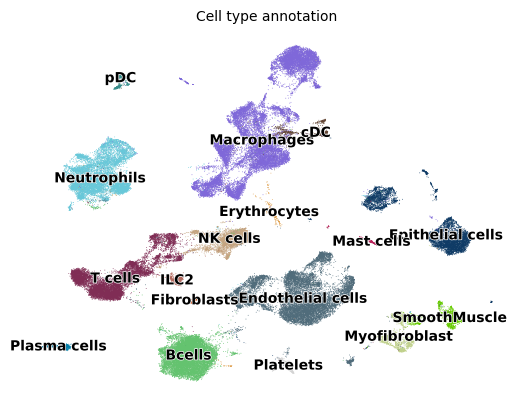

In [4]:
scv.pl.scatter(superdata, basis='umap_scVI', color='celltype_rough', legend_loc='on data', frameon=False, title='Cell type annotation', color_map=celltype_rough_colors)

# Internal 34 / Rev3 14: Better GSEA reporting

Line 190. Why do the authors only report a couple of genes? Certainly, they did a pathway assessment and could define key genes in various canonical pathways - in the supplement would be fine. Also what are the top 10 genes in each group and do they cross reference?

# Internal 2 / Rev1 Major 2: Th17 freq

Is the frequency of Th17 cells higher in the lungs of infected Roborovski hamsters compared to Syrian hamsters?

## Identify Th17 cells

In [9]:
tdata = sc.read_h5ad(data_path / "Cov19Hamster_timecourse_integrated_tcells.h5")
mask = ~tdata.obs_names.isin(superdata.obs_names)
print(f"Removing {mask.sum()} cells from tdata")
tdata = tdata[~mask]
tdata.obs = superdata.obs.loc[tdata.obs_names].copy()

Removing 263 cells from tdata


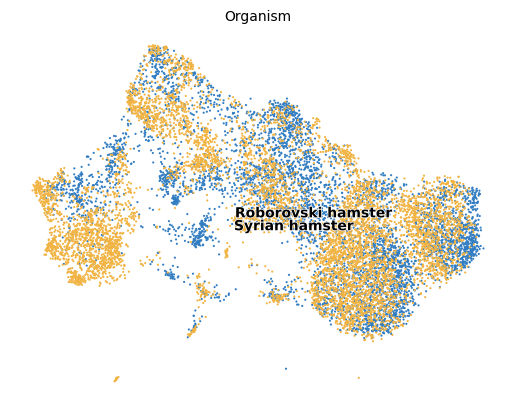

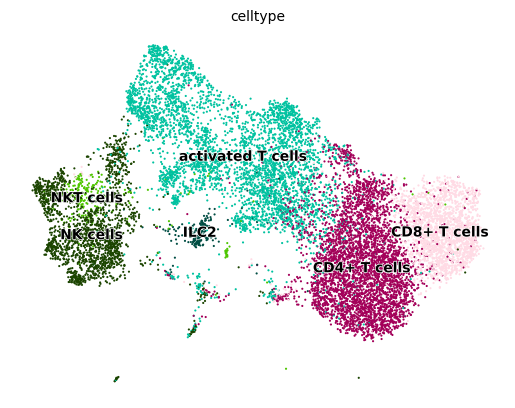

In [10]:
scv.pl.scatter(tdata, basis='umap_scVI', legend_loc='on data', frameon=False, color='Organism', palette=Organism_colors)
scv.pl.scatter(tdata, basis='umap_scVI', legend_loc='on data', frameon=False, color='celltype')

In [38]:
markers =  ["Il17a", "Il17f", "Il21", "Il22", "Rorc", "Il6ra", "Il21r", "Il23r", "Stat3", "Ccr6"]
markers = list(np.intersect1d(markers, tdata.var_names))
good_markers = ['Ccr6', 'Il21r', 'Rorc', 'Stat3', 'Cd4', 'Cd8a', 'Cd8b', 'Socs1', 'Socs3', 'Tbx21', 'Gata3', 'Foxp3', 'Ccr4',
                'Ifng', 'Tnf',
                'Ccr5', 'Ccr1', 'Ccr2', 'Cxcr3', 'Ccr3'
                ]

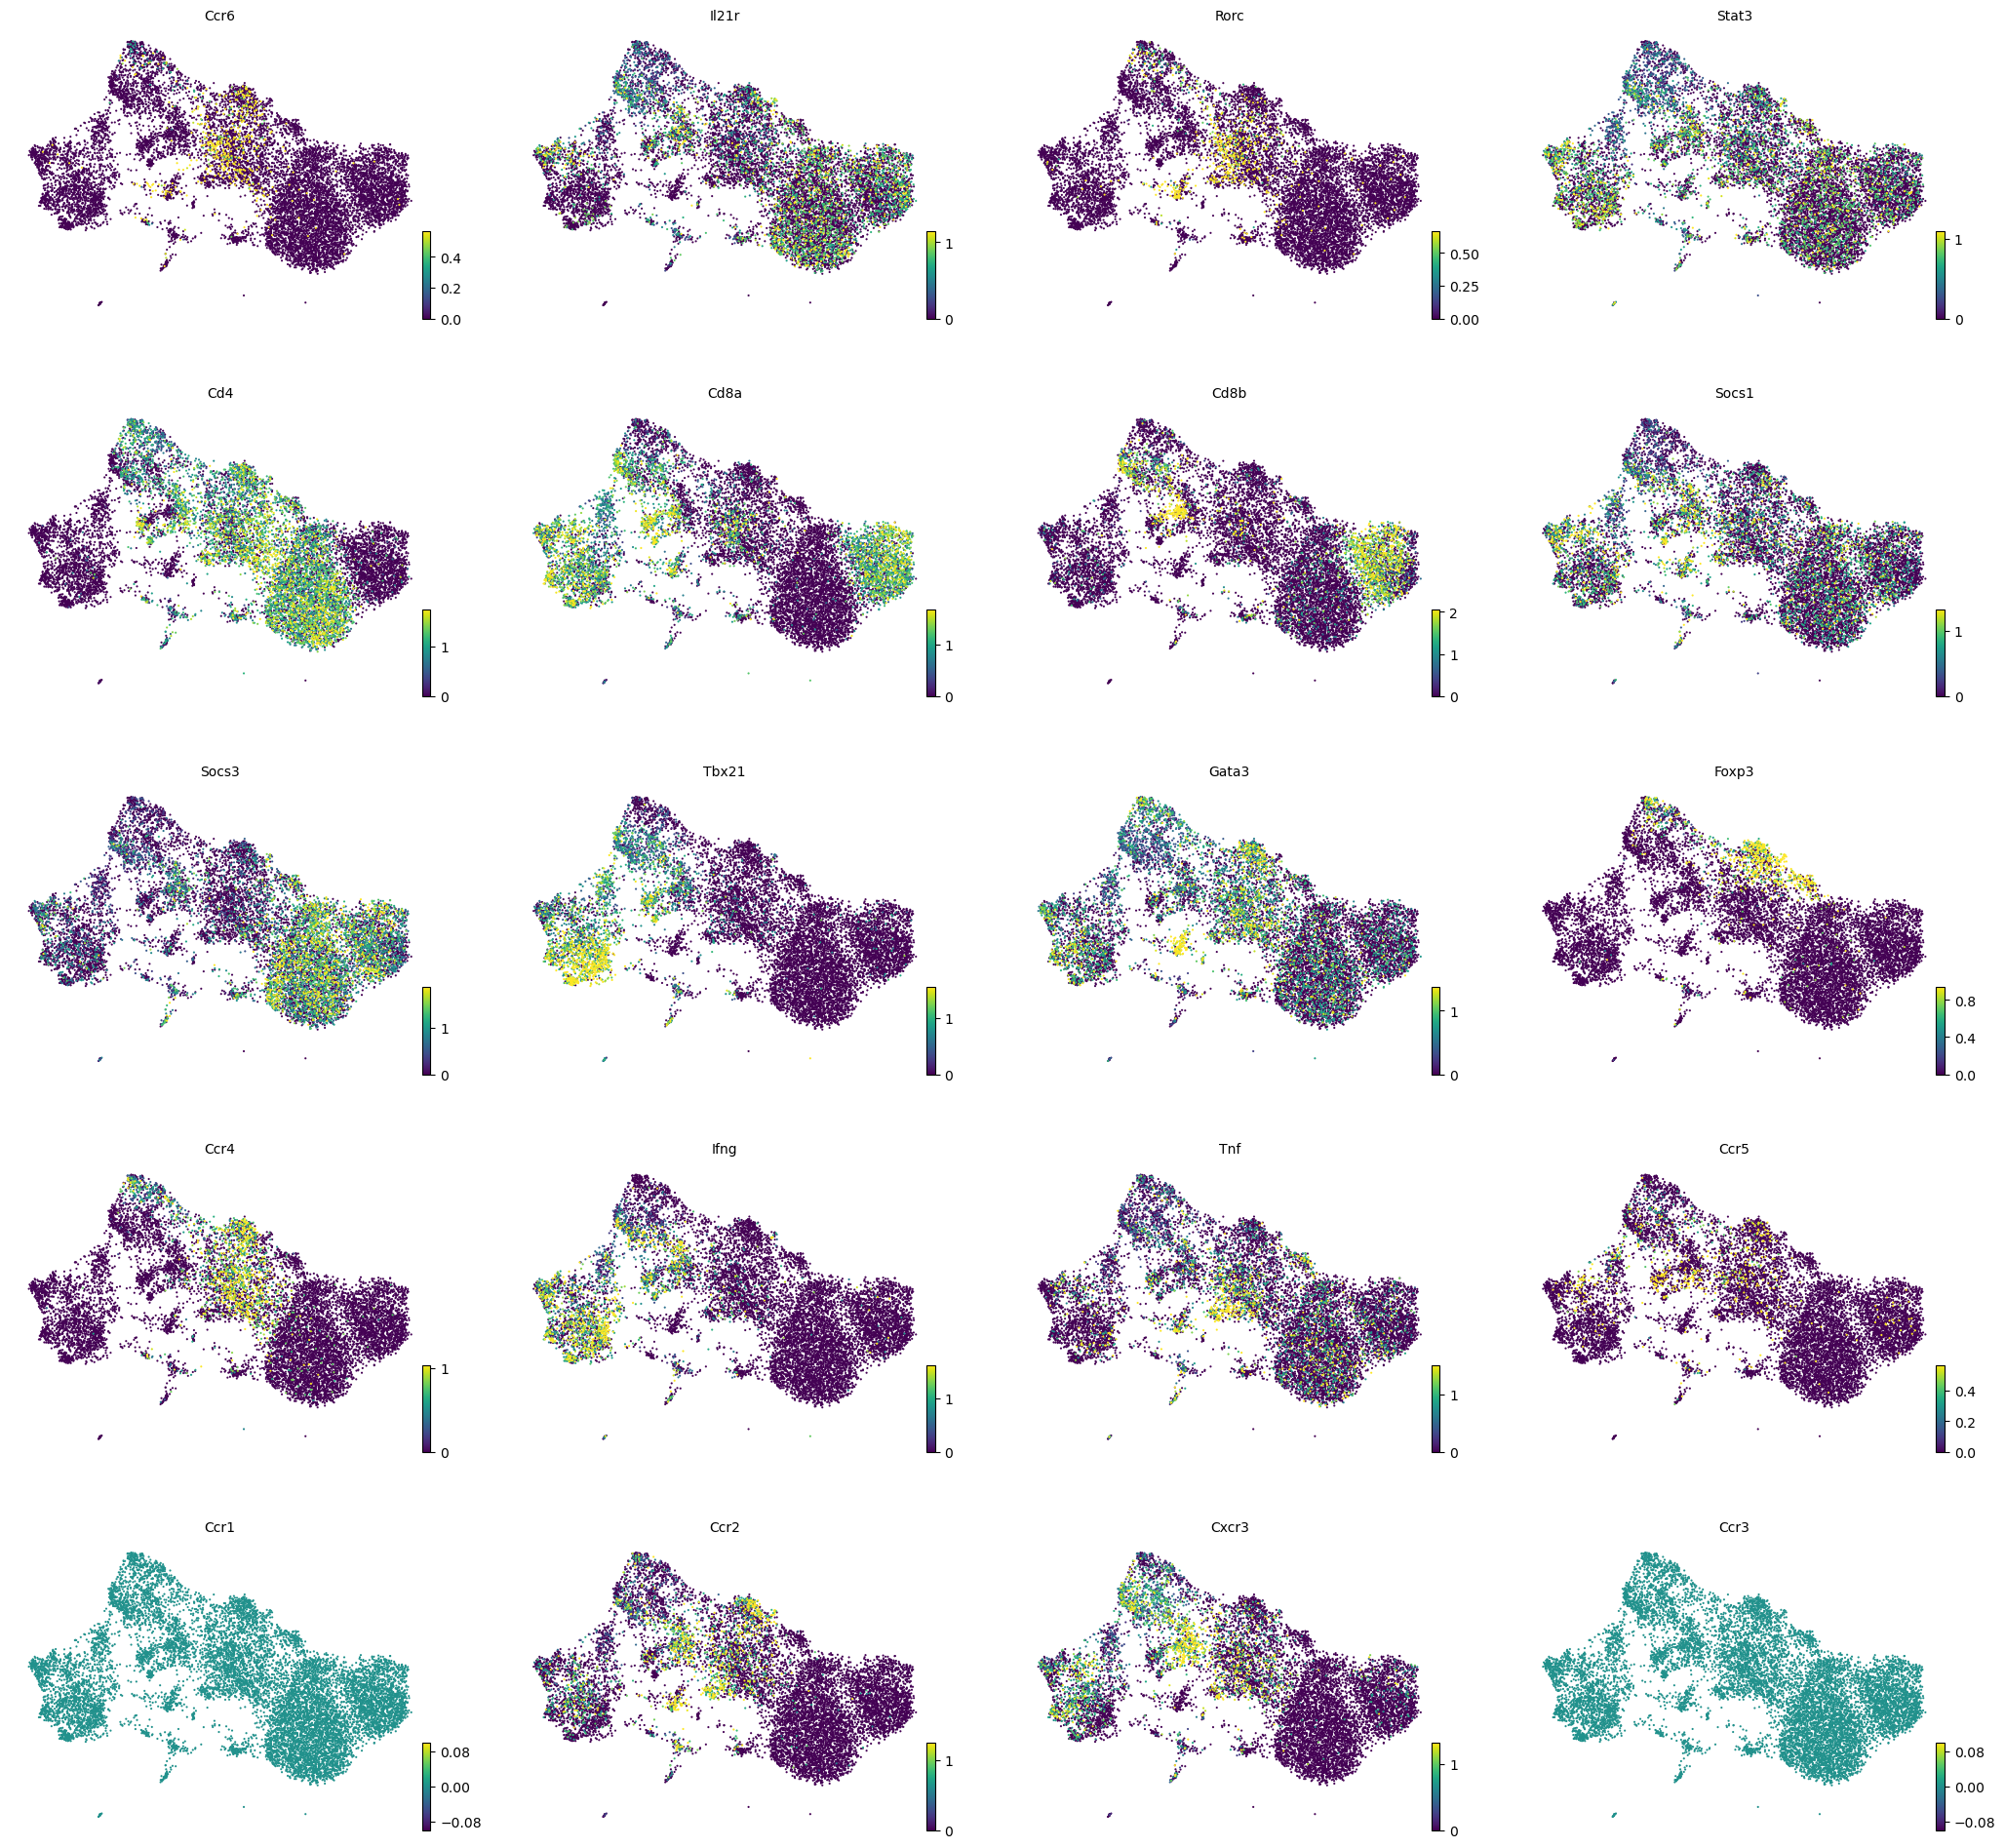

In [39]:
scv.pl.scatter(tdata, basis='umap_scVI', legend_loc='on data', frameon=False, color=['Rorc', 'Cd4', 'Cd8a', 'Socs3', 'Tbx21', 'Gata3', 'Foxp3', 'Eomes', 'Ifng', 'Tnf', 'Cxcr3'], ncols=3, perc=[3, 97])

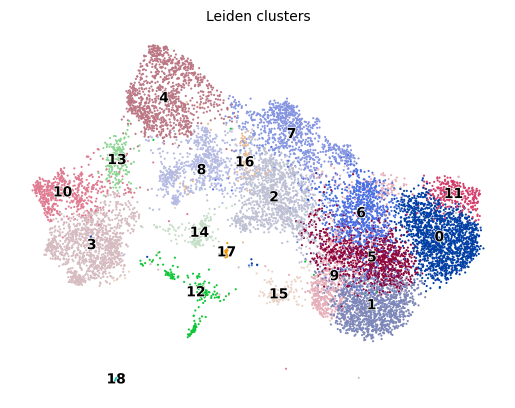

In [43]:
sc.tl.leiden(tdata, resolution=1.5, neighbors_key='neighbors_scVI')
scv.pl.scatter(tdata, basis='umap_scVI', legend_loc='on data', frameon=False, color='leiden', title='Leiden clusters', color_map='tab20')

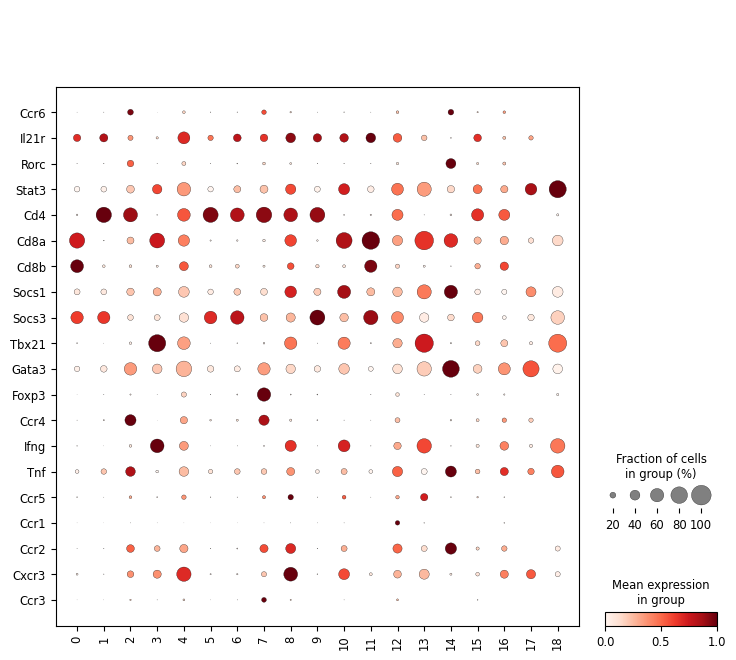

In [44]:
sc.pl.dotplot(tdata, good_markers, groupby='leiden', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True)

In [45]:
df = extract_df(tdata, ['leiden'] + good_markers)
sdf = df.groupby('leiden').mean()
sdf['Cd8'] = sdf[['Cd8a', 'Cd8b']].mean(axis=1)

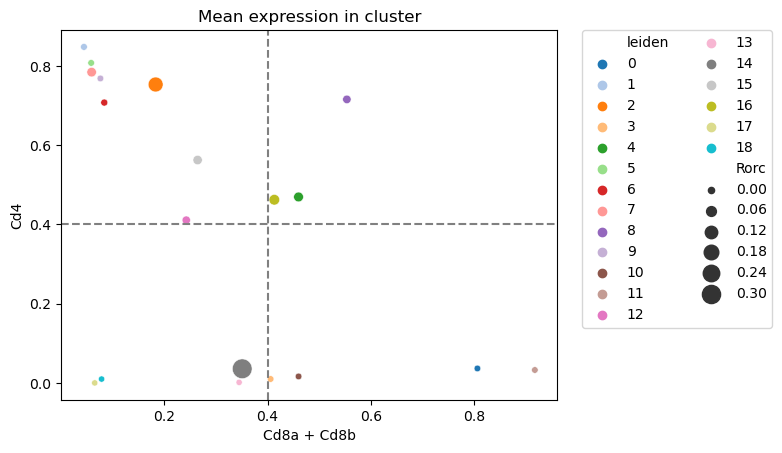

In [46]:
sns.scatterplot(data=sdf, x='Cd8', y='Cd4', hue=sdf.index, palette='tab20', size='Rorc', sizes=(20, 200))
pl.axvline(0.4, color='grey', linestyle='--')
pl.axhline(0.4, color='grey', linestyle='--')
pl.ylabel('Cd4')
pl.xlabel('Cd8a + Cd8b')
pl.title('Mean expression in cluster')
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)
pl.show()

In [47]:
types = {
    'CD4+CD8-': list(sdf[sdf['Cd8'] < 0.4].index),
    'CD4+CD8+': list(sdf[(sdf['Cd4'] > 0.4) & (sdf['Cd8'] > 0.4)].index),
}

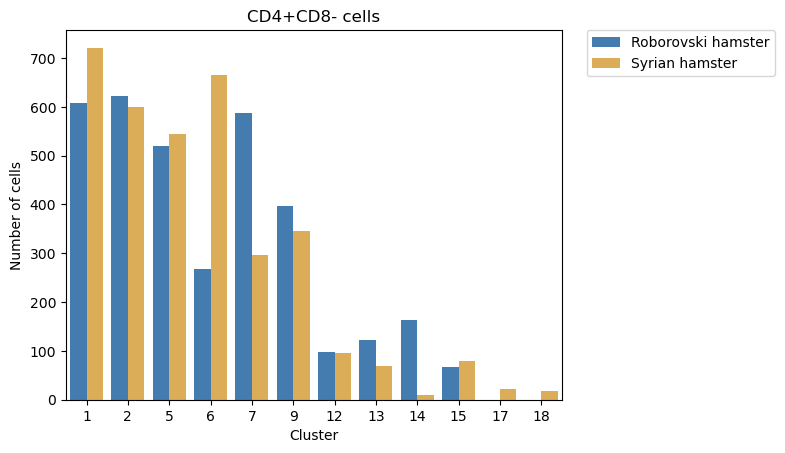

In [48]:
numbers = extract_df(tdata[tdata.obs.leiden.isin(types['CD4+CD8-'])], ['leiden', 'Organism']).value_counts(['leiden', 'Organism']).reset_index()
sns.barplot(data=numbers, x='leiden', y=0, hue='Organism', palette=Organism_colors)
pl.ylabel('Number of cells')
pl.xlabel('Cluster')
pl.title('CD4+CD8- cells')
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.show()

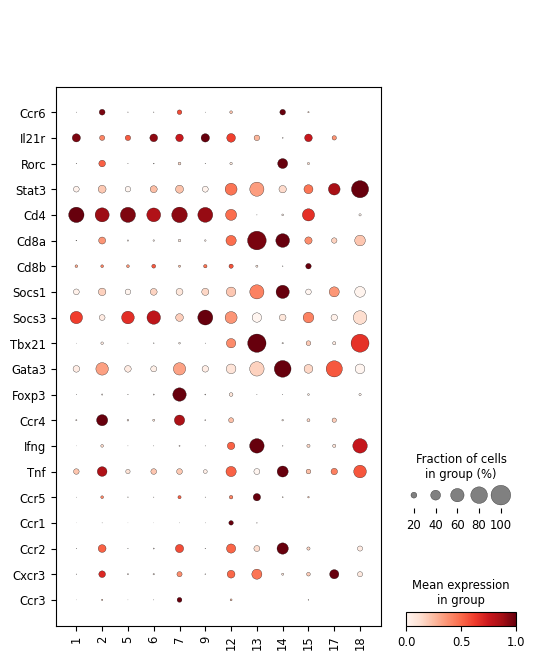

In [49]:
# We are looking for Rorc+ Foxp3- Ccr6+ cells
# Also good: Stat3+ Socs1+ Socs3-
data = tdata[tdata.obs.leiden.isin(types['CD4+CD8-'])]
sc.pl.dotplot(data, good_markers, groupby='leiden', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True)

>Geraldine: Du kannst ruhig alle RORc und CD4 CD3 positiven zusammenschmeissen (Cluster 5, 9, 14) Cluster 6 und 10 würde ich rauslassen, Cluster 15 scheinen CD8 zu sein, die RORc expremieren, die können wir auch rauslassen.
% TH17 / CD4 wäre die richtige Darstellung, FC nimmt man eigentlich nicht bei Zellpopulationen und passt hier ja auch nicht.

### Gating RORC

In [ ]:
# Calc Th17 frequency
df = extract_df(tdata[tdata.obs.leiden.isin(types['CD4+CD8-'])], ['leiden', 'Time', 'hamster', 'Organism', 'Dosage', 'Rorc'])
df['subtype'] = 'RORC- CD4+CD8- T cells'
df['subtype'][df.Rorc > 0.2] = 'RORC+ CD4+CD8- T cells'
counts = df.value_counts(['Time', 'hamster', 'Organism', 'Dosage', 'subtype'], sort=False).unstack(fill_value=0)
counts['percent Rorc+'] = (counts['RORC+ CD4+CD8- T cells'] / counts.sum(axis=1))
counts = counts.reset_index(drop=False)
counts['Dosage_Time'] = counts['Dosage'].astype(str) + '_' + counts['Time'].astype(str)

# Plot Th17 frequency
data = counts.reset_index()
with sns.axes_style('whitegrid'):
    fig, ax= pl.subplots(figsize=(10, 5))
    sns.barplot(data=data, x='Dosage_Time', y='percent Rorc+', hue='Organism', palette=Organism_colors)
    sns.swarmplot(data=data, x='Dosage_Time', y='percent Rorc+', hue='Organism', palette=Organism_colors, edgecolor='k', linewidth=2, dodge=True, alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter(pl.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Rorc+ frequency\n(w.r.t. all CD4+CD8- T cells)')
ax.set_xlabel('Virus Dose and Time after Infection')

from statannotations.Annotator import Annotator
pairs = [
    (("0 pfu_0 dpi", "Syrian hamster"), ("0 pfu_0 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_2 dpi", "Syrian hamster"), ("1x10$^5$ pfu_2 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_2 dpi", "Syrian hamster"), ("1x10$^4$ pfu_2 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_3 dpi", "Syrian hamster"), ("1x10$^5$ pfu_3 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_3 dpi", "Syrian hamster"), ("1x10$^4$ pfu_3 dpi", "Roborovski hamster")),
         ]
annot = Annotator(ax, pairs, data=data, x='Dosage_Time', y='percent Rorc+', hue='Organism', )
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
annot.apply_and_annotate()

pl.xticks(rotation=45, ha='right')
pl.title('Rorc+ frequency in CD4+CD8- T cells')
pl.savefig("../results/figures/Revision/Rev1_Major2_Th17_frequency_rorc_gated.pdf", bbox_inches='tight', dpi=300)
pl.show()

## Compare Frequency of Th17 cells

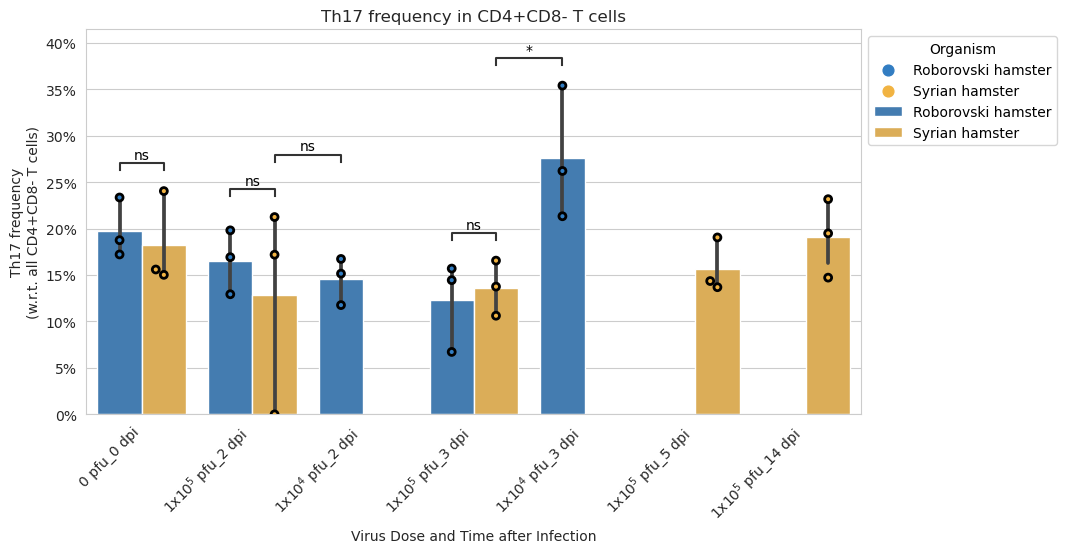

In [60]:
th17_cluster = ['2']
# Calc Th17 frequency
df = extract_df(tdata[tdata.obs.leiden.isin(types['CD4+CD8-'])], ['leiden', 'Time', 'hamster', 'Organism', 'Dosage'])
df['subtype'] = 'CD4+CD8- T cells'
df['subtype'][df.leiden.isin(th17_cluster)] = 'Th17 cells'
counts = df.value_counts(['Time', 'hamster', 'Organism', 'Dosage', 'subtype'], sort=False).unstack(fill_value=0)
counts['Th17_frequency'] = (counts['Th17 cells'] / counts.sum(axis=1))
counts = counts.reset_index(drop=False)
counts['Dosage_Time'] = counts['Dosage'].astype(str) + '_' + counts['Time'].astype(str)

# Plot Th17 frequency
data = counts.reset_index()
with sns.axes_style('whitegrid'):
    fig, ax= pl.subplots(figsize=(10, 5))
    sns.barplot(data=data, x='Dosage_Time', y='Th17_frequency', hue='Organism', palette=Organism_colors)
    sns.swarmplot(data=data, x='Dosage_Time', y='Th17_frequency', hue='Organism', palette=Organism_colors, edgecolor='k', linewidth=2, dodge=True, alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter(pl.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Th17 frequency\n(w.r.t. all CD4+CD8- T cells)')
ax.set_xlabel('Virus Dose and Time after Infection')

from statannotations.Annotator import Annotator
pairs = [
    (("0 pfu_0 dpi", "Syrian hamster"), ("0 pfu_0 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_2 dpi", "Syrian hamster"), ("1x10$^5$ pfu_2 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_2 dpi", "Syrian hamster"), ("1x10$^4$ pfu_2 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_3 dpi", "Syrian hamster"), ("1x10$^5$ pfu_3 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_3 dpi", "Syrian hamster"), ("1x10$^4$ pfu_3 dpi", "Roborovski hamster")),
         ]
annot = Annotator(ax, pairs, data=data, x='Dosage_Time', y='Th17_frequency', hue='Organism', )
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
annot.apply_and_annotate()

pl.xticks(rotation=45, ha='right')
pl.title('Th17 frequency in CD4+CD8- T cells')
pl.savefig("../results/figures/Revision/Rev1_Major2_Th17_frequency.pdf", bbox_inches='tight', dpi=300)
pl.show()

In [ ]:
th17_cluster = ['2']
# Calc Th17 frequency
df = extract_df(tdata, ['leiden', 'Time', 'hamster', 'Organism', 'Dosage'])
df['subtype'] = 'T cells'
df['subtype'][df.leiden.isin(th17_cluster)] = 'Th17 cells'
counts = df.value_counts(['Time', 'hamster', 'Organism', 'Dosage', 'subtype'], sort=False).unstack(fill_value=0)
counts['Th17_frequency'] = (counts['Th17 cells'] / counts.sum(axis=1))
counts = counts.reset_index(drop=False)
counts['Dosage_Time'] = counts['Dosage'].astype(str) + '_' + counts['Time'].astype(str)

# Plot Th17 frequency
data = counts.reset_index()
with sns.axes_style('whitegrid'):
    fig, ax= pl.subplots(figsize=(10, 5))
    sns.barplot(data=data, x='Dosage_Time', y='Th17_frequency', hue='Organism', palette=Organism_colors)
    sns.swarmplot(data=data, x='Dosage_Time', y='Th17_frequency', hue='Organism', palette=Organism_colors, edgecolor='k', linewidth=2, dodge=True, alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter(pl.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Th17 frequency\n(w.r.t. all T cells)')
ax.set_xlabel('Virus Dose and Time after Infection')

from statannotations.Annotator import Annotator
pairs = [
    (("0 pfu_0 dpi", "Syrian hamster"), ("0 pfu_0 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_2 dpi", "Syrian hamster"), ("1x10$^5$ pfu_2 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_2 dpi", "Syrian hamster"), ("1x10$^4$ pfu_2 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_3 dpi", "Syrian hamster"), ("1x10$^5$ pfu_3 dpi", "Roborovski hamster")),
    (("1x10$^5$ pfu_3 dpi", "Syrian hamster"), ("1x10$^4$ pfu_3 dpi", "Roborovski hamster")),
         ]
annot = Annotator(ax, pairs, data=data, x='Dosage_Time', y='Th17_frequency', hue='Organism', )
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
annot.apply_and_annotate()

pl.xticks(rotation=45, ha='right')
pl.title('Th17 frequency in all T cells')
pl.savefig("../results/figures/Revision/Rev1_Major2_Th17_frequency_wrt_all_tcells.pdf", bbox_inches='tight', dpi=300)
pl.show()

## Finding Th1 T cells (failed)

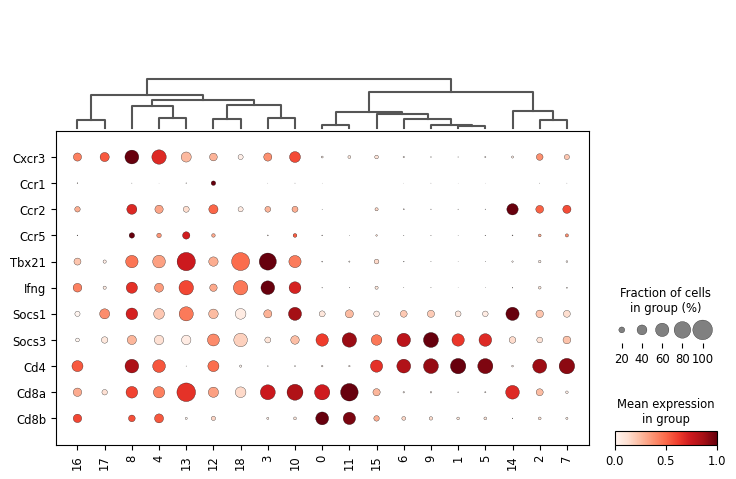

In [69]:
th1_markers = ['Cxcr3', 'Ccr1', 'Ccr2', 'Ccr5', 'Tbx21', 'Ifng', 'Socs1', 'Socs3', 'Cd4', 'Cd8a', 'Cd8b']
sc.pl.dotplot(tdata, th1_markers, groupby='leiden', use_raw=False, dendrogram=True, standard_scale='var', swap_axes=True, show=False)
pl.show()

# Internal 3 / Rev1 Major 3b: COV2 entry receptors

Additionally, it would be pertinent to discuss whether Sars-Cov2 entry receptors, like ACE2, CD147, AXL, TMPRSS2 and many others, are more prominently expressed in Roborovski hamster neutrophils compared to those in Syrian hamsters.

In [80]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10094153/
entry_receptors = [
    'Ace2', 'Tmprss2', 'Ctsl', 'Nrp1', # main entry factors
    'Bsg', # Cd147
    'Axl', 'Kremen1'
]
# not found: 'Cd209', 'Havcr1' aka Tim1
# Expression too low:  'Asgr1', 'Clec4g' 

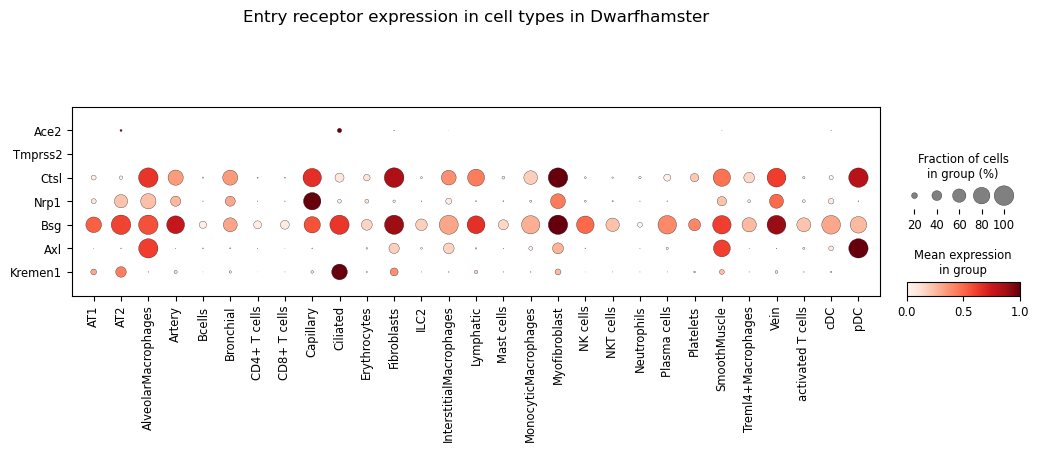

In [81]:
sc.pl.dotplot(superdata[superdata.obs.organism=='Dwarfhamster'], 
              entry_receptors, groupby='celltype', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True,
              title='Entry receptor expression in cell types in Dwarfhamster')

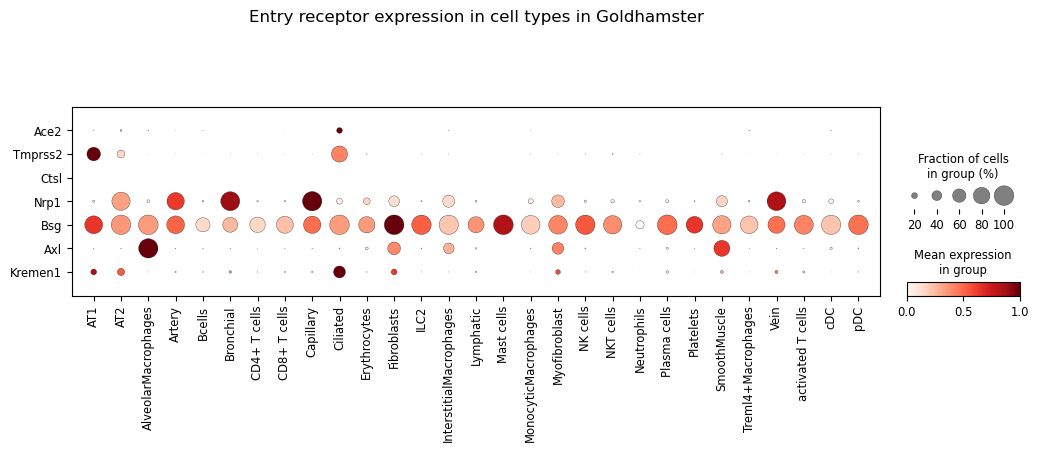

In [82]:
sc.pl.dotplot(superdata[superdata.obs.organism=='Goldhamster'], 
              entry_receptors, groupby='celltype', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True,
              title='Entry receptor expression in cell types in Goldhamster')

In [83]:
percent_expressings = {}
mean_expressions = {}
for Organism in ['Roborovski hamster', 'Syrian hamster']:
    df = extract_df(superdata[superdata.obs.Organism==Organism], ['celltype'] + entry_receptors)
    # this is black magic here
    df.set_index('celltype', inplace=True)
    percent_expressing = pd.concat(
        {gene: (df > 0).value_counts(['celltype', gene], normalize=False, sort=False).loc[:, True].reindex(sorted(df.index.unique()), fill_value=0) \
            / df.value_counts(['celltype'], sort=False).reset_index().set_index('celltype')[0] \
            for gene in entry_receptors if df[gene].sum()>0}, axis=1
    ).fillna(0).T * 100
    percent_expressing.columns = percent_expressing.columns.astype(str)
    percent_expressing.sort_index(axis=1, inplace=True)

    df = extract_df(superdata[superdata.obs.Organism==Organism], ['celltype'] + entry_receptors)
    mean_expression = df.groupby('celltype').mean().T
    mean_expression.columns = mean_expression.columns.astype(str)
    mean_expression.sort_index(axis=1, inplace=True)
    
    percent_expressings[Organism] = percent_expressing
    mean_expressions[Organism] = mean_expression

In [84]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Wedge
def split_dotplot(color_df1, size_df1, color_df2, size_df2, figsize=None, ax=None, dpi=None, title=None, show=True, cmap='Reds'):
    if ax is None:
            fig, ax = fig, ax = pl.subplots(figsize=figsize, dpi=dpi)
    for side, color_df, size_df in zip(['left', 'right'], [color_df1, color_df2], [size_df1, size_df2]):
        N, M = color_df.shape

        x, y = np.meshgrid(np.arange(M), np.arange(N))
        s = size_df.values.astype(int)  # TODO
        c = color_df.values.astype(float)  # TODO

        max_radius = 0.8
        R = s/s.max()/2 * max_radius
        if side == 'left':
            circles = [Wedge((j,i), r, 90, 270) for r, j, i in zip(R.flat, x.flat, y.flat)]
        else:
            circles = [Wedge((j,i), r, 270, 90) for r, j, i in zip(R.flat, x.flat, y.flat)]
        col = PatchCollection(circles, array=c.flatten(), cmap=cmap, edgecolors='k', linewidths=1, alpha=0.8)
        ax.add_collection(col)
        
    # set ticks and labels
    ylabels = color_df.index
    xlabels = color_df.columns
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
            xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_xticklabels(xlabels, rotation=45, ha='right')
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.set_yticklabels(ylabels)
    
    ax.grid(which='minor')
    ax.set_aspect('equal')
    if title is not None:ax.set_title(title)
    fig.colorbar(col, ax=ax, label='NES', pad=0.05, aspect=10, shrink=0.25)  # TODO
    if show: pl.show()

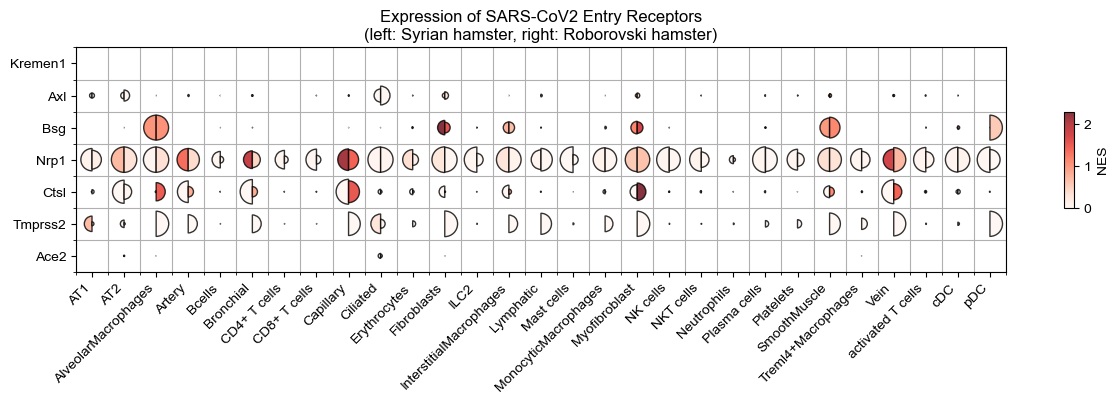

In [10]:
split_dotplot(mean_expressions['Syrian hamster'], percent_expressings['Syrian hamster'], 
              mean_expressions['Roborovski hamster'], percent_expressings['Roborovski hamster'], 
              figsize=(15,5), ax=None, dpi=None, title="Expression of SARS-CoV2 Entry Receptors\n(left: Syrian hamster, right: Roborovski hamster)", 
              show=False)
pl.savefig("../results/figures/Revision/Rev1_Major3b_Entry_receptor_expression_splitdots.pdf", bbox_inches='tight', dpi=300)
pl.show()

In [55]:
# only neutros
neutros = superdata[superdata.obs.celltype=='Neutrophils'].copy()
df = extract_df(neutros, ['Time', 'replicate', 'Organism', 'Dosage']+ entry_receptors)

In [56]:
# cell-wise expression
cdf = df.set_index(['Time', 'replicate', 'Organism', 'Dosage']).stack().reset_index().rename(columns={'level_4': 'gene', 0: 'expression'})
# sample-wise mean expression
sdf = df.groupby(['Time', 'replicate', 'Organism', 'Dosage']).mean().stack().reset_index().rename(columns={'level_4': 'gene', 0: 'expression'})

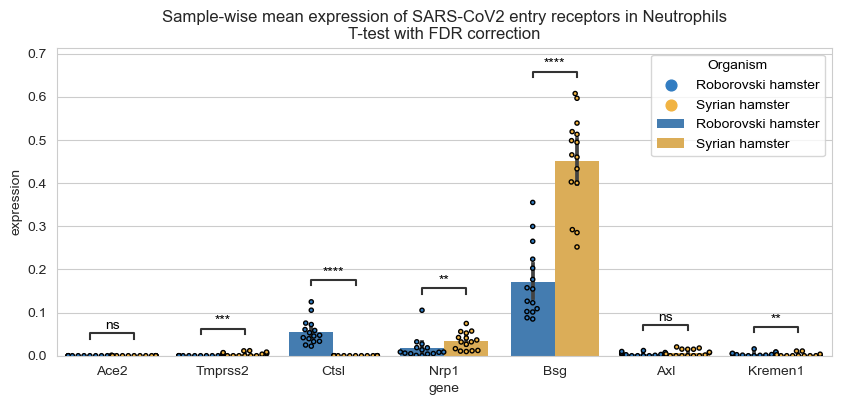

In [89]:
from statannotations.Annotator import Annotator
with sns.axes_style('whitegrid'):
    fig, ax= pl.subplots(figsize=(10, 4))
sns.barplot(data=sdf, hue='Organism', y='expression', x='gene', palette=Organism_colors)
sns.swarmplot(data=sdf, hue='Organism', y='expression', x='gene', palette=Organism_colors, edgecolor='k', linewidth=1, dodge=True, alpha=1, size=3)
pl.title('Sample-wise mean expression of SARS-CoV2 entry receptors in Neutrophils\nT-test with FDR correction')

pairs=[((gene, "Roborovski hamster"), (gene, "Syrian hamster")) for gene in entry_receptors]
annotator = Annotator(ax, pairs, data=sdf, hue='Organism', y='expression', x='gene', verbose=0)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='fdr_bh', verbose=0)
annotator.apply_and_annotate()

pl.show()

In [71]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
# test between Organisms
pseudo_bulk = df.groupby(['Organism', 'Time', 'Dosage', 'replicate']).mean().dropna().reset_index()
pvals = []
for gene in entry_receptors:
    a = pseudo_bulk[(pseudo_bulk.Organism=='Syrian hamster')][gene]
    b = pseudo_bulk[(pseudo_bulk.Organism=='Roborovski hamster')][gene]
    pvals.append([gene, ttest_ind(a, b, equal_var=False).pvalue])
corrected = multipletests([x[1] for x in pvals], method='fdr_bh')[1]
res = pd.DataFrame(pvals, columns=['gene', 'pval'])
res['adj_pval'] = corrected

# Internal 7 / Rev1 Minor 2: Ribo RNA and damage

Line 252: in scRNAseq experiments, increased expression of ribosomal RNA is sometimes associated with damaged cells. This point should be discussed.

In [9]:
superdata.var_names.str.startswith('Rps').sum(), superdata.var_names.str.startswith('Rpl').sum()

(44, 49)

In [10]:
is_ribo = np.logical_or(superdata.var_names.str.startswith('Rps'), superdata.var_names.str.startswith('Rpl'))
superdata.obs['percent_ribo'] = superdata[:, is_ribo].layers['counts'].sum(1).A1 / superdata.layers['counts'].sum(1).A1 * 100

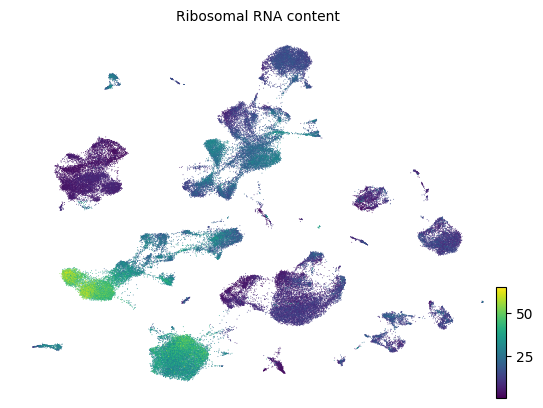

In [12]:
scv.pl.scatter(superdata, basis='umap_scVI', color='percent_ribo', frameon=False, title='Ribosomal RNA content', color_map='viridis', show=False)
pl.savefig("../results/figures/Revision/Rev1_Minor2_ribo_umap.png", bbox_inches='tight', dpi=300)
pl.show()

In [35]:
df = extract_df(superdata, ['celltype', 'Organism', 'Dosage', 'Time', 'replicate', 'percent_ribo', 'percent.mt'])
df = df[df.celltype.isin(['Neutrophils', 'Artery', 'Vein', 'Bronchial', 'Capillary'])]
df.celltype = df.celltype.astype('str')
q_means = df.groupby(['celltype', 'Dosage', 'Time', 'Organism', 'replicate']).mean().reset_index()

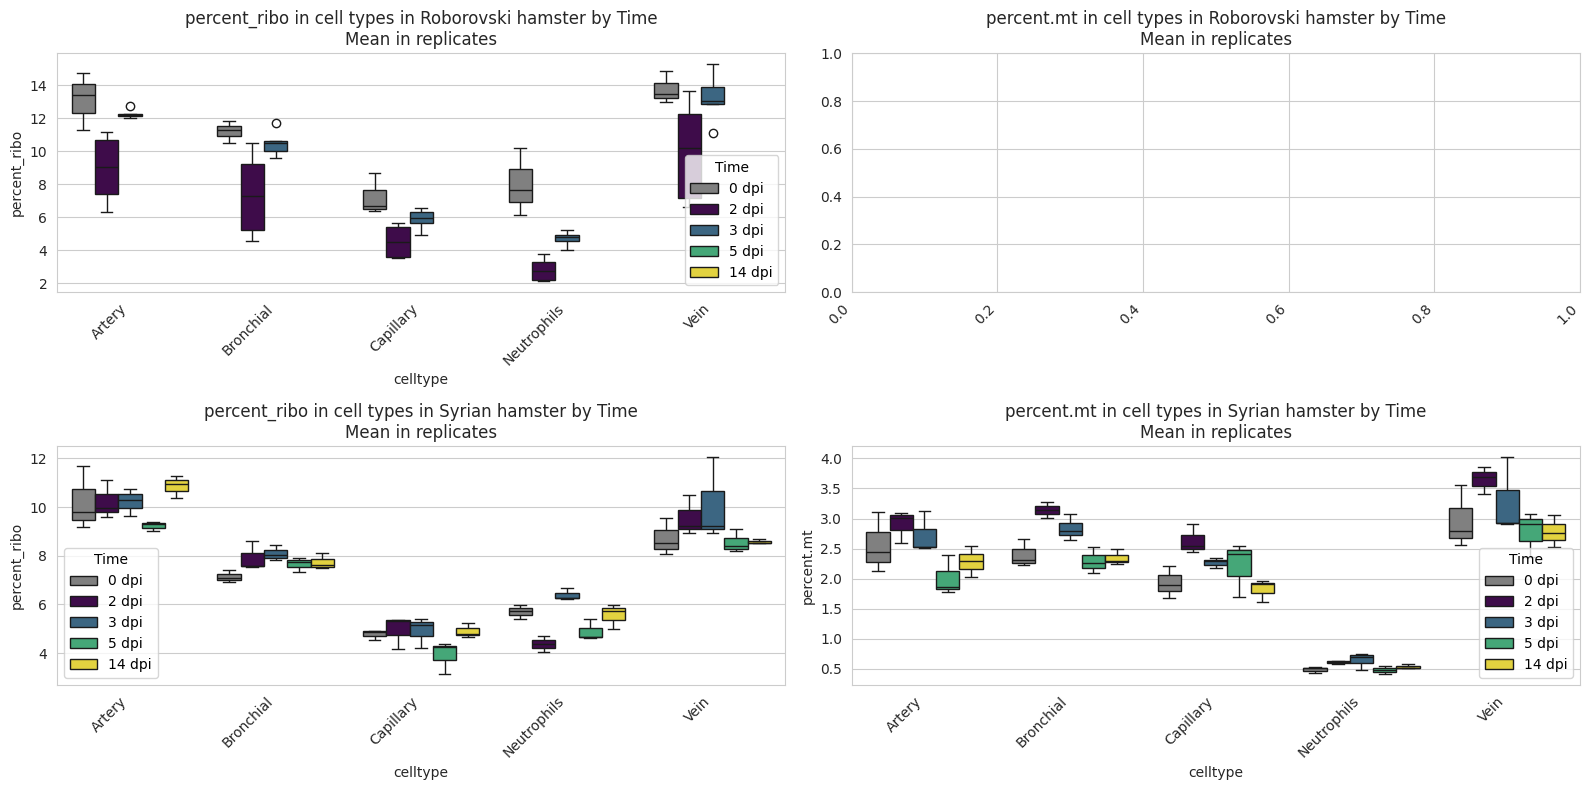

In [42]:
with sns.axes_style('whitegrid'):
    fig, axss = pl.subplots(figsize=(8*2, 4*2), ncols=2, nrows=2, sharex=False)
for Organism, axs in zip(['Roborovski hamster', 'Syrian hamster'], axss):
    for key, ax in zip(['percent_ribo', 'percent.mt'], axs):
        data = q_means[q_means.Organism == Organism]
        data.Time = data.Time.cat.remove_unused_categories()
        data = data[~data[key].isna()]
        sns.boxplot(data=data, x='celltype', y=key, hue='Time', palette=Time_colors, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_title(f'{key} in cell types in {Organism} by Time\nMean in replicates')
        # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
pl.tight_layout()
pl.show()

In [45]:
# Foldchange w.r.t. Time 0 dpi
# This has worked before :(
baseline_mean = q_means[q_means.Time=='0 dpi'].groupby(['celltype', 'Organism']).mean().percent_ribo
ribos = q_means.set_index(['celltype', 'Organism', 'Dosage', 'Time', 'replicate']).dropna()
fcs = {}
for celltype in ribos.index.levels[0].unique():
    for organism in ribos.index.levels[1].unique():
        fcs[(celltype, organism)] = ribos.loc[celltype, organism].percent_ribo / baseline_mean[celltype, organism]
res = pd.concat(fcs, axis=0).reset_index().rename(columns={'level_0': 'celltype', 'level_1': 'Organism', 'percent_ribo': 'Foldchange'})
res['l2fc'] = np.log2(res.Foldchange)

TypeError: category dtype does not support aggregation 'mean'

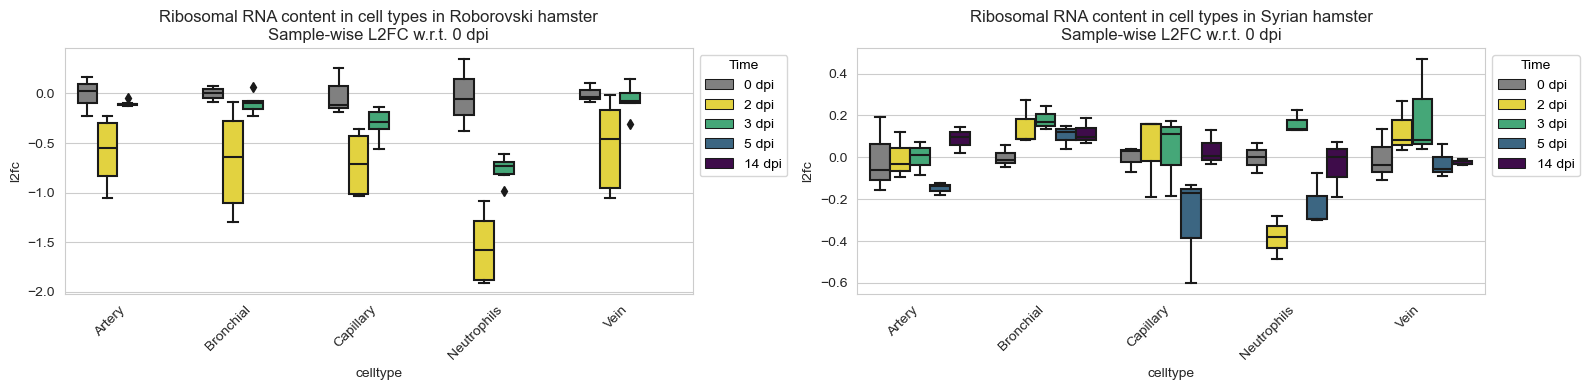

In [17]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1,2, figsize=(8*2, 4))
for Organism in ['Roborovski hamster', 'Syrian hamster']:
    ax = axs[0] if Organism == 'Roborovski hamster' else axs[1]
    data = res[res.Organism == Organism]
    sns.boxplot(data=data, x='celltype', y='l2fc', hue='Time', palette=Time_colors, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'Ribosomal RNA content in cell types in {Organism}\nSample-wise L2FC w.r.t. 0 dpi')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
pl.tight_layout()
pl.savefig("../results/figures/Revision/Rev1_Minor2_ribo_content_foldchange.pdf", bbox_inches='tight', dpi=300)
pl.show()

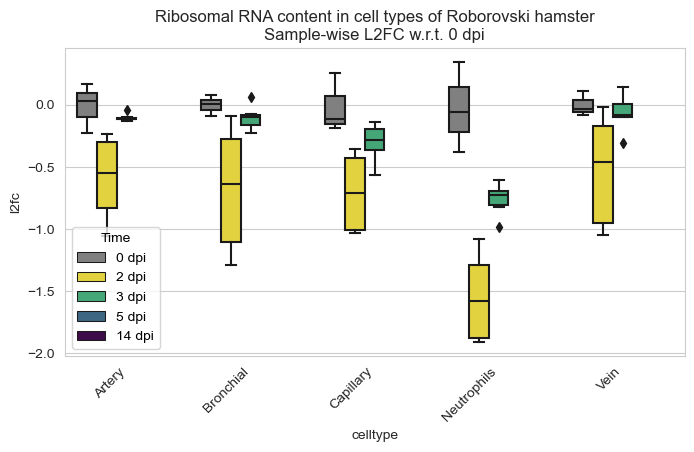

In [18]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8, 4))
sns.boxplot(data=res[res.Organism != 'Syrian hamster'], x='celltype', y='l2fc', hue='Time', palette=Time_colors)
pl.xticks(rotation=45, ha='right')
pl.title('Ribosomal RNA content in cell types of Roborovski hamster\nSample-wise L2FC w.r.t. 0 dpi')
pl.show()

# Internal 3 / Rev1 Major 3a: Virus RNA distribution

In Supplementary Figure 1D, there appears to be a higher presence of Sars-Cov2 RNA in neutrophils from Roborovski hamsters compared to those from Syrian hamsters. An exploration of how Sars-Cov2 RNA is distributed among various cell types would provide valuable insights and should be addressed.

In [5]:
df = extract_df(superdata, ['celltype', 'Organism', 'Dosage', 'Time', 'replicate', 'SCoV2_sum', 'SCoV2_load', 'SCoV2_detected'])
df.SCoV2_detected = df.SCoV2_detected.astype('int')

In [53]:
# mean per celltype
sdf = df.groupby(['celltype', 'Organism', 'Dosage', 'Time', 'replicate']).mean()
sdf['cell_counts'] = df.groupby(['celltype', 'Organism', 'Dosage', 'Time', 'replicate']).size()
sdf['cells_with_virus'] = df.groupby(['celltype', 'Organism', 'Dosage', 'Time', 'replicate']).sum()['SCoV2_detected']
sdf = sdf.reset_index().dropna()
sdf = sdf[sdf.Time != '0 dpi']
sdf = sdf[sdf.Time != '14 dpi']
sdf = sdf[sdf.Dosage != '1x10$^4$ pfu']

In [54]:
sdf.head()

celltype            Organism        Dosage   Time replicate  SCoV2_sum  \
33      AT1  Roborovski hamster  1x10$^5$ pfu  2 dpi         1   2.285714   
34      AT1  Roborovski hamster  1x10$^5$ pfu  2 dpi         2   0.266667   
35      AT1  Roborovski hamster  1x10$^5$ pfu  2 dpi         3  36.214286   
36      AT1  Roborovski hamster  1x10$^5$ pfu  3 dpi         1   0.857143   
37      AT1  Roborovski hamster  1x10$^5$ pfu  3 dpi         2   0.200000   

    SCoV2_load  SCoV2_detected  cell_counts  cells_with_virus  
33    0.048979        0.285714            7                 2  
34    0.003364        0.266667           15                 4  
35    2.117773        0.214286           14                 3  
36    0.030431        0.571429            7                 4  
37    0.002551        0.200000            5                 1

In [72]:
per_celltype_stats.SCoV2_detected.median()

0.026595744680851064

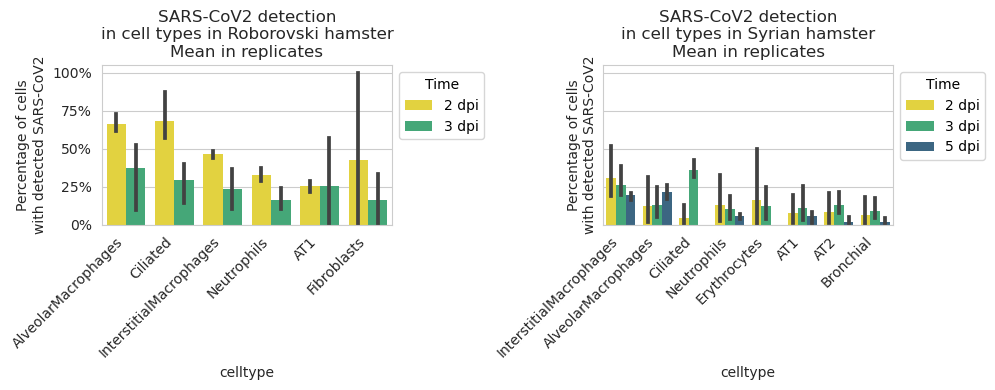

In [79]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, 2, figsize=(5*2, 4), sharex=False, sharey=True)
for Organism in ['Roborovski hamster', 'Syrian hamster']:
    ax = axs[0] if Organism == 'Roborovski hamster' else axs[1]
    data = sdf[sdf.Organism == Organism]
    per_celltype_stats = data.groupby(['celltype']).median().sort_values('SCoV2_detected', ascending=False)
    order = per_celltype_stats.index
    data = data[data.celltype.isin(per_celltype_stats[per_celltype_stats.SCoV2_detected > 1.5 * per_celltype_stats.SCoV2_detected.median()].index)]
    order = order[order.isin(data.celltype.unique())]
    data.Time.cat.remove_unused_categories(inplace=True)
    sns.barplot(data=data, x='celltype', y='SCoV2_detected', hue='Time', palette=Time_colors, ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'SARS-CoV2 detection\nin cell types in {Organism}\nMean in replicates')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_ylabel('Percentage of cells\nwith detected SARS-CoV2')
    ax.yaxis.set_major_formatter(pl.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pl.tight_layout()
pl.savefig("../results/figures/Revision/Rev1_Major3a_SCoV2_detection_barplot.pdf", bbox_inches='tight', dpi=300)
pl.show()

# Internal 12 / Rev2 2b: Baseline gene sets

In [49]:
nulldata_r = superdata[(superdata.obs.Organism=='Roborovski hamster') & (superdata.obs.Time=='0 dpi')].copy()
sc.pp.filter_genes(nulldata_r, min_cells=10)
nulldata_s = superdata[(superdata.obs.Organism=='Syrian hamster') & (superdata.obs.Time=='0 dpi')].copy()
sc.pp.filter_genes(nulldata_s, min_cells=10)

In [50]:
# now do ORA?
from gseapy import enrichr
def gseapy_enrichr(gene_list, background, species='human',
                  gene_sets=None, enrichr_lib_path=None,
                  description='pathway', cutoff=1, min_genes=1, **kwargs):
    '''
    Internally makes all genes human because enrichr handles it that way in their libs it seems.
    Background can be a integer number or a list of gene names.
    '''
    enrichr_lib_path = Path('/Users/peidli/work/utils/scRNAseq_signature_collection/enrichr_libraries/') if enrichr_lib_path is None else enrichr_lib_path
    if species == 'human' and gene_sets==None:
        gene_sets = [enrichr_lib_path / f'{key}.gmt' for key in ['KEGG_2022_Human', 'ReactomePathways_2022_Human', 'MSigDB_Hallmark_2022_Human']]
    elif species == 'mouse' and gene_sets==None:
        gene_sets = [enrichr_lib_path / f'{key}.gmt' for key in ['ReactomePathways_2022_Mouse', 'MSigDB_Hallmark_2022_Mouse']]  # TODO KEGG_2019_Mouse is human all caps!!!
    gene_sets = [x.as_posix() for x in gene_sets]
    background = background if type(background)==int else specify_genes(background, 'human')  # always make background human
    if type(gene_list) == pd.core.indexes.base.Index:
        gene_list = list(gene_list)

    results=enrichr(
        gene_list=specify_genes(gene_list, species),
        gene_sets=gene_sets,
        cutoff=1,   # leave this cutoff at 1!!!
        background=background, **kwargs
        )
    res = results.results
    if len(res)==0:
        print('No hits found during GOEA.')
    else:
        res = res[res['Adjusted P-value'] < cutoff].sort_values('Adjusted P-value', ascending=True)
        res['members'] = [int(x.split('/')[0]) for x in res.Overlap]
        res = res[res['members'] >= min_genes]
        res = res.reset_index(drop=True)#.drop(['Old P-value', 'Old Adjusted P-value'], axis=1)
        return res

In [51]:
sc.pp.highly_variable_genes(nulldata_s, n_top_genes=2000, batch_key='celltype', flavor='seurat_v3', layer='counts', span=1)

ZeroDivisionError: division by zero

In [41]:
mask = (nulldata_s.var.highly_variable)# & (nulldata_r.var.highly_variable_nbatches > 6)
genes = list(nulldata_s.var_names[mask])
background = nulldata_s.var_names[nulldata_s.X.sum(0).A1 > 50]
res = gseapy_enrichr(genes, 
               background, 
               species='human',
               cutoff=0.05,
               min_genes=10
               )

In [32]:
res

Gene_set                                               Term  \
0    CUSTOM20322520448         REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION   
1    CUSTOM11967650944                                      KEGG_RIBOSOME   
2    CUSTOM20322520448  REACTOME_RESPONSE_OF_EIF2AK4_GCN2_TO_AMINO_ACI...   
3    CUSTOM20322520448         REACTOME_EUKARYOTIC_TRANSLATION_INITIATION   
4    CUSTOM20322520448               REACTOME_SELENOAMINO_ACID_METABOLISM   
..                 ...                                                ...   
123  CUSTOM20322520448                     REACTOME_BIOLOGICAL_OXIDATIONS   
124  CUSTOM20322520704                     HALLMARK_XENOBIOTIC_METABOLISM   
125  CUSTOM20322520448  REACTOME_SIGNALING_BY_RHO_GTPASES_MIRO_GTPASES...   
126  CUSTOM20322520448          REACTOME_SIGNALING_BY_TGFB_FAMILY_MEMBERS   
127  CUSTOM20322520448  REACTOME_TRANSCRIPTIONAL_REGULATION_OF_GRANULO...   

    Overlap       P-value  Adjusted P-value  Odds Ratio  \
0     58/81  3.341052e-31      4.299934e-28    5.089862   
1     55/76  4.896094e-30      8.029594e-28    5.136269   
2     58/87  1.452601e-28      9.347488e-26    4.738056   
3    61/105  3.428499e-25      1.103119e-22    4.132512   
4     57/93  2.746243e-25      1.103119e-22    4.352627   
..      ...           ...               ...         ...   
123   22/83  3.076882e-03      3.882301e-02    1.863765   
124  27/125  2.080670e-02      4.161340e-02    1.514493   
125  94/496  3.454264e-03      4.274651e-02    1.327987   
126   23/89  3.554825e-03      4.357200e-02    1.816264   
127   11/32  4.052563e-03      4.874438e-02    2.441455   

                                                 Genes  members  
0    RPL3;RPS15;RPL28;RPS3A;RPS18;EEF1B2;RPS11;RPL3...       58  
1    RPS15;RPL3;RPL28;RPS18;RPS11;RPL35;RPS12;RPL8;...       55  
2    RPL3;RPS15;RPL28;RPS3A;RPS18;RPS11;RPL35;RPS12...       58  
3    RPL3;RPS15;EIF2B2;RPL28;RPS3A;RPS18;RPS11;RPL3...       61  
4    RPL3;RPS15;RPL28;RPS3A;RPS18;RPS11;RPL35;RPS12...       57  
..                                                 ...      ...  
123  FMO2;ALDH1A1;AOC3;CBR3;AIP;GSTM1;CYP4B1;CYP1A1...       22  
124  IGFBP4;RBP4;TMEM176B;ALAS1;MT2A;IRF8;ID2;ARG1;...       27  
125  NCF1;ARHGAP28;TUBA1B;ACTB;ZWILCH;SOWAHC;RACGAP...       94  
126  BMP2;JUNB;PPP1CB;ITGB5;GREM2;TGFB3;MYC;COL1A2;...       23  
127  MYC;H2AX;CEBPA;CEBPB;H3C14;H2BC3;DEK;CEBPE;TFD...       11  

[128 rows x 8 columns]

In [34]:
# well, shit
res[res['Term'].str.contains('INFLAMMATORY')]

Gene_set                            Term Overlap       P-value  \
36  CUSTOM20322520704  HALLMARK_INFLAMMATORY_RESPONSE  47/141  1.315830e-08   

    Adjusted P-value  Odds Ratio  \
36      8.223936e-08    2.348435   

                                                Genes  members  
36  IL1B;CD14;C5AR1;CD40;CD69;RGS1;CSF3R;LTA;IFITM...       47

In [53]:
# pseudo-bulk the control samples, then do ORA on top std genes
from itertools import product
from tqdm.auto import tqdm
def pseudo_bulk(adata, keys, layer='counts', min_cells_per_group=1, dtype=int):
    """
    Pseudo-bulk count data from adata grouped by one or multiple keys.
    
    Parameters
    ----------
    adata: AnnData
        Annotated data matrix.
    keys: str or list of str
        Keys to group by.
    layer: str or None
        Layer to use. If None, uses adata.X.
    min_cells_per_group: int
        Minimum number of cells per group to be included. Per default all non-empty groups are included.
    dtype: type
        Data type of the returned matrix. Per default int. Set to float if you want to use non-integer data.

    Returns
    -------
    sc.AnnData
        Pseudo-bulk data.
    """
    
    X = []
    Y = []
    for gs in tqdm(product(*[pd.unique(adata.obs[key]) for key in keys])):
        mask = np.logical_and.reduce([adata.obs[key]==g for g, key in zip(gs, keys)])  # select cells
        ncells = sum(mask)
        if ncells < min_cells_per_group: continue
        Y.append(list(gs)+[ncells])
        X_ = adata[mask].layers[layer] if layer!=None else adata[mask].X  # select data
        X.append(np.array(np.sum(X_, axis=0), dtype=dtype)[0])  # sum over cells
    obs=pd.DataFrame(Y, columns=list(keys)+['ncells'])
    return sc.AnnData(np.array(X), obs=obs, var=adata.var)

In [73]:
pdata = pseudo_bulk(nulldata_s, ['replicate'], layer='counts', min_cells_per_group=1, dtype=int)
pdata.var['std'] = np.std(pdata.X, axis=0)
pdata.var['mean'] = np.mean(pdata.X, axis=0)

0it [00:00, ?it/s]

In [71]:
genes = list(pdata.var['std'].sort_values(ascending=False).index)[:100]
background = nulldata_s.var_names[nulldata_s.X.sum(0).A1 > 50]
res = gseapy_enrichr(genes, 
               background, 
               species='human',
               cutoff=0.05,
               min_genes=10
               )

In [72]:
res

Gene_set                                               Term  \
0   CUSTOM20362470080         REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION   
1   CUSTOM20365526016                                      KEGG_RIBOSOME   
2   CUSTOM20362470080  REACTOME_RESPONSE_OF_EIF2AK4_GCN2_TO_AMINO_ACI...   
3   CUSTOM20362470080               REACTOME_SELENOAMINO_ACID_METABOLISM   
4   CUSTOM20362470080  REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN...   
5   CUSTOM20362470080               REACTOME_NONSENSE_MEDIATED_DECAY_NMD   
6   CUSTOM20362470080         REACTOME_EUKARYOTIC_TRANSLATION_INITIATION   
7   CUSTOM20362470080           REACTOME_CELLULAR_RESPONSE_TO_STARVATION   
8   CUSTOM20362470080                       REACTOME_INFLUENZA_INFECTION   
9   CUSTOM20362470080  REACTOME_REGULATION_OF_EXPRESSION_OF_SLITS_AND...   
10  CUSTOM20362470080               REACTOME_SIGNALING_BY_ROBO_RECEPTORS   
11  CUSTOM20362470080                           REACTOME_RRNA_PROCESSING   
12  CUSTOM20362470080                               REACTOME_TRANSLATION   
13  CUSTOM20362470080  REACTOME_METABOLISM_OF_AMINO_ACIDS_AND_DERIVAT...   
14  CUSTOM20362470080                REACTOME_NERVOUS_SYSTEM_DEVELOPMENT   
15  CUSTOM20362470080             REACTOME_CELLULAR_RESPONSES_TO_STIMULI   
16  CUSTOM20362470080                     REACTOME_DEVELOPMENTAL_BIOLOGY   
17  CUSTOM20362470080  REACTOME_SARS_COV_2_MODULATES_HOST_TRANSLATION...   
18  CUSTOM20362470080                        REACTOME_INFECTIOUS_DISEASE   
19  CUSTOM20362470080                         REACTOME_METABOLISM_OF_RNA   
20  CUSTOM20362470080  REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_O...   
21  CUSTOM20362470080              REACTOME_SARS_COV_2_HOST_INTERACTIONS   
22  CUSTOM20362470080                      REACTOME_SARS_COV_2_INFECTION   
23  CUSTOM20362470080                       REACTOME_SARS_COV_INFECTIONS   
24  CUSTOM20362469760                            HALLMARK_MYC_TARGETS_V1   
25  CUSTOM20362470080                  REACTOME_NEUTROPHIL_DEGRANULATION   
26  CUSTOM20362470080                      REACTOME_INNATE_IMMUNE_SYSTEM   

   Overlap        P-value  Adjusted P-value  Odds Ratio  \
0    54/85  6.711072e-100      2.865628e-97  180.282148   
1    52/81   2.839345e-96      7.098361e-95  174.729935   
2    53/93   4.066306e-94      8.681562e-92  158.328680   
3   53/104   1.832089e-90      1.955755e-88  141.543944   
4   53/104   1.832089e-90      1.955755e-88  141.543944   
5   53/106   7.346938e-90      6.274285e-88  138.864690   
6   53/110   1.058766e-88      7.534884e-87  133.797142   
7   53/141   2.478612e-81      1.511953e-79  104.237939   
8   53/143   6.239300e-81      3.330226e-79  102.769448   
9   53/150   1.393605e-79      6.611880e-78   97.937087   
10  54/188   1.856674e-75      7.928000e-74   81.132113   
11  53/191   5.424856e-73      2.105831e-71   76.727690   
12  54/277   3.113202e-65      1.107781e-63   54.735464   
13  53/282   5.787705e-63      1.901038e-61   51.649054   
14  56/435   3.352271e-57      1.022443e-55   37.321676   
15  56/625   3.651687e-48      1.039514e-46   25.599287   
16  56/647   2.568733e-47      6.855306e-46   24.686365   
17   27/46   4.150986e-47      1.042630e-45  106.133787   
18  58/760   3.793832e-46      8.999814e-45   22.581900   
19  53/620   4.365478e-44      9.810838e-43   22.901149   
20   27/56   6.994614e-44      1.493350e-42   87.282825   
21  29/168   4.782419e-32      9.724252e-31   31.999398   
22  29/243   3.275286e-27      6.357032e-26   22.016240   
23  29/325   1.531599e-23      2.843447e-22   16.365967   
24  10/189   1.579988e-06      3.317975e-05    7.988382   
25  12/366   1.962981e-05      3.104417e-04    4.960074   
26  17/763   5.238250e-05      7.988331e-04    3.423977   

                                                Genes  members  
0   RPL13A;RPL7A;RPL3;RPS15;RPL28;RPS18;RPL35;RPS1...       54  
1   RPL13A;RPL7A;RPL3;RPS15;RPL28;RPS18;RPL35;RPS1...       52  
2   RPL13A;RPL7A;RPL3;RPS15;RPL28;RP

# Internal 18 / Rev2 8: sex

## Expression of cell-type specific genes

In [89]:
# protein coding genes (got em from chatgpt)
chr_y = ['Sly','Uty','Eif2s3y','Ddx3y','Usp9y','Kdm5d','Jarid1d','Ube1y1','Ube1y2','Uty2','Uty3','Uty4']
chr_y = [x for x in chr_y if x in superdata.var_names]
chr_x = ['Kdm6a','Kdm5c','Kdm6b','Kdm5d','Uba1','Eif2s3x','Atrx','Mecp2','Nsdhl','Mid1','Pja1','Phf6']
chr_x = [x for x in chr_x if x in superdata.var_names]

# From Sam email, 13.02.2024
chr_y =  'Zfy1, Uba1y, Kdm5d, Eif2s3y, Uty, Ddx3y, Usp9y, Zfy2, Sry, Rbmy'.split(', ')
chr_y = [x for x in chr_y if x in superdata.var_names]
print('Chr Y genes in data:', chr_y)
# chr_x = ['Xist'] # Xist is NOT in our data
# chr_x = [x for x in chr_x if x in superdata.var_names]
print('Chr X genes in data:', chr_x)


# From Sam email, 15.02.2024
testo_genes = ['Hsd3b1', 'Cyp17a1', 'Srd5a1']
testo_genes = [x for x in testo_genes if x in superdata.var_names]
print('Chr Y genes in data:', testo_genes)

Chr Y genes in data: ['Kdm5d', 'Uty', 'Ddx3y']
Chr X genes in data: ['Kdm6a', 'Kdm5c', 'Kdm6b', 'Kdm5d', 'Uba1', 'Atrx', 'Mecp2', 'Nsdhl', 'Mid1', 'Pja1', 'Phf6']
Chr Y genes in data: ['Cyp17a1', 'Srd5a1']


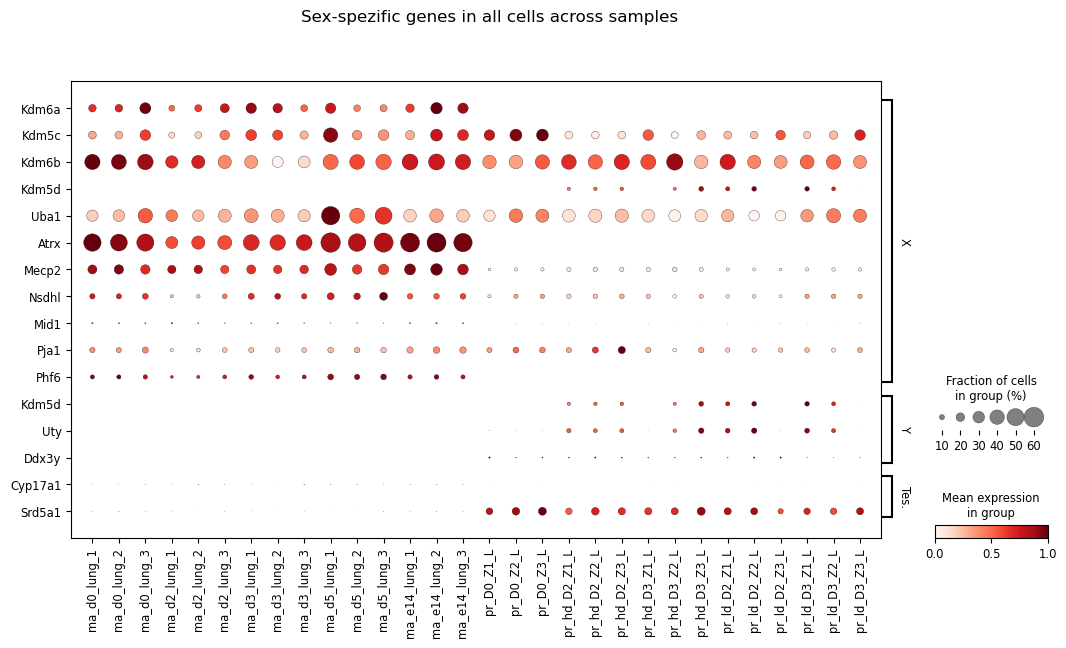

In [90]:
sc.pl.dotplot(superdata, 
              {'X': chr_x, 'Y': chr_y, 'Testosterone': testo_genes},
              groupby='orig.ident', use_raw=False, dendrogram=False, standard_scale='var',
              swap_axes=True, title='Sex-specific genes in all cells across samples',
              )

In [96]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('../results/figures/Revision/multipage_sex_specificity_roughcelltypes.pdf') as pdf:
    for celltype in superdata.obs.celltype_rough.unique():
        sc.pl.dotplot(superdata[superdata.obs.celltype_rough==celltype], 
                      {'X': chr_x, 'Y': chr_y, 'Testosterone': testo_genes},
                      groupby='orig.ident', use_raw=False, dendrogram=False, standard_scale='var',
                      swap_axes=True, title=f'Sex-specific genes in {celltype} across samples',
                      show=False
                      )
        pdf.savefig(bbox_inches='tight')
        pl.close()

## Looking at blood

In [157]:
# wget -O GSE162208_RAW.tar 'http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE162208&format=file'
# looking at blood
# bdatas = {x.name: sc.read_10x_h5(x) for x in Path('/scratch/peidli/PanCov19').glob('*-blood-*.h5')}
bdatas = {}
for x in tqdm(Path('/Users/peidli/work/data/COVID').glob('*-blood-*.h5')):
    bdata = sc.read_10x_h5(x)
    sc.pp.filter_cells(bdata, min_genes=200)
    bdata.var_names_make_unique()
    bdatas[x.name] = bdata

0it [00:00, ?it/s]

In [158]:
# This is taking too damn long
bdata = sc.concat(bdatas, index_unique='-', label='sample_id')

In [164]:
bdata.obs.sample_id = [x.split('_')[1] for x in bdata.obs.sample_id]

In [165]:
# protein coding genes (got em from chatgpt)
chr_y = ['Sly','Uty','Eif2s3y','Ddx3y','Usp9y','Kdm5d','Jarid1d','Ube1y1','Ube1y2','Uty2','Uty3','Uty4']
chr_y = [x for x in chr_y if x in bdata.var_names]
chr_x = ['Kdm6a','Kdm5c','Kdm6b','Kdm5d','Uba1','Eif2s3x','Atrx','Mecp2','Nsdhl','Mid1','Pja1','Phf6']
chr_x = [x for x in chr_x if x in bdata.var_names]

# From Sam email, 13.02.2024
chr_y =  'Zfy1, Uba1y, Kdm5d, Eif2s3y, Uty, Ddx3y, Usp9y, Zfy2, Sry, Rbmy'.split(', ')
chr_y = [x for x in chr_y if x in bdata.var_names]
print('Chr Y genes in data:', chr_y)
# chr_x = ['Xist'] # Xist is NOT in our data
# chr_x = [x for x in chr_x if x in bdata.var_names]
print('Chr X genes in data:', chr_x)


# From Sam email, 15.02.2024
testo_genes = ['Hsd3b1', 'Cyp17a1', 'Srd5a1']
testo_genes = [x for x in testo_genes if x in bdata.var_names]
print('Testo genes in data:', testo_genes)

Chr Y genes in data: []
Chr X genes in data: ['Kdm6a', 'Kdm5c', 'Kdm6b', 'Uba1', 'Atrx', 'Mecp2', 'Nsdhl', 'Mid1', 'Pja1', 'Phf6']
Testo genes in data: ['Cyp17a1', 'Srd5a1']


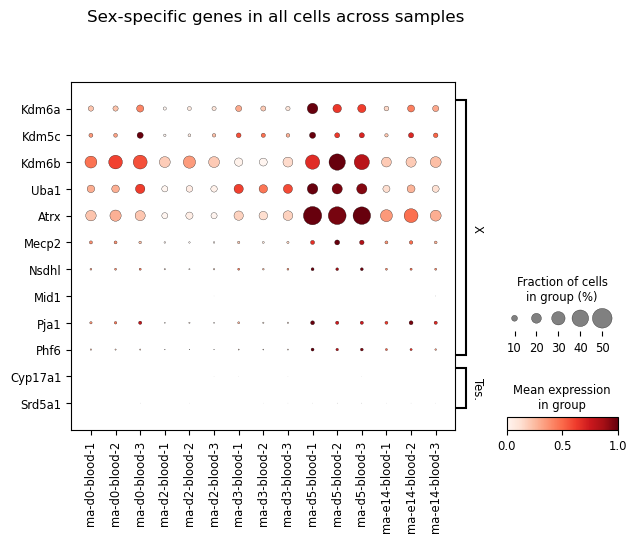

In [166]:
sc.pl.dotplot(bdata, 
              {'X': chr_x, 'Testosterone': testo_genes},
              groupby='sample_id', use_raw=False, dendrogram=False, standard_scale='var',
              swap_axes=True, title='Sex-specific genes in all cells across samples',
              )

# Internal 5 / Rev1 Major 5: Subclustering of NK cells and Neutrophils

The analysis of scRNAseq data is certainly well done, yet it could benefit from further detail. While subtypes of macrophages and endothelial cells have been identified, a similar sub-clustering analysis for neutrophils and NK cells is lacking. Conducting such an analysis could unveil potential variations in the distribution of the different sub-clusters between hamsters with mild and severe disease.

I still think this is hella stupid.

## NK cells

In [136]:
tdata = sc.read_h5ad(data_path / "Cov19Hamster_timecourse_integrated_tcells.h5")
mask = ~tdata.obs_names.isin(superdata.obs_names)
print(f"Removing {mask.sum()} cells from tdata")
tdata = tdata[~mask]
tdata.obs = superdata.obs.loc[tdata.obs_names].copy()
tdata.obs.celltype.cat.remove_unused_categories(inplace=True)
tdata.obs.celltype_rough.cat.remove_unused_categories(inplace=True)

Removing 263 cells from tdata


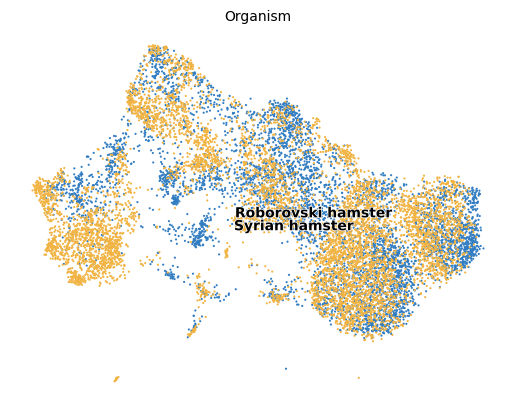

In [137]:
scv.pl.scatter(tdata, basis='umap_scVI', legend_loc='on data', frameon=False, color='Organism', palette=Organism_colors)

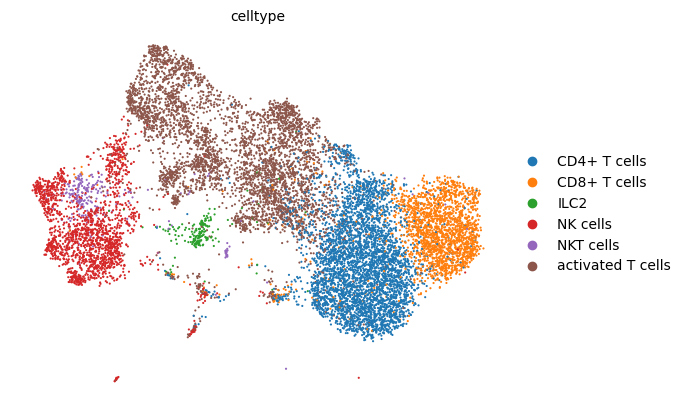

In [138]:
scv.pl.scatter(tdata, basis='umap_scVI', frameon=False, color='celltype', legend_loc='right margin')

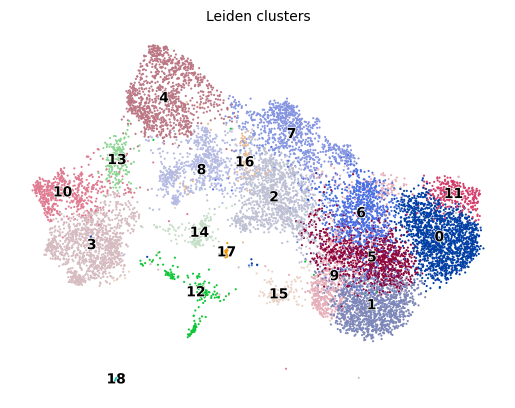

In [100]:
sc.tl.leiden(tdata, resolution=1.5, neighbors_key='neighbors_scVI')
scv.pl.scatter(tdata, basis='umap_scVI', legend_loc='on data', frameon=False, color='leiden', title='Leiden clusters', color_map='tab20')

In [140]:
ndata = tdata[tdata.obs.celltype.isin(['NK cells', 'NKT cells', 'ILC2'])].copy()
sc.pp.neighbors(ndata, use_rep='X_scVI')
sc.tl.umap(ndata)

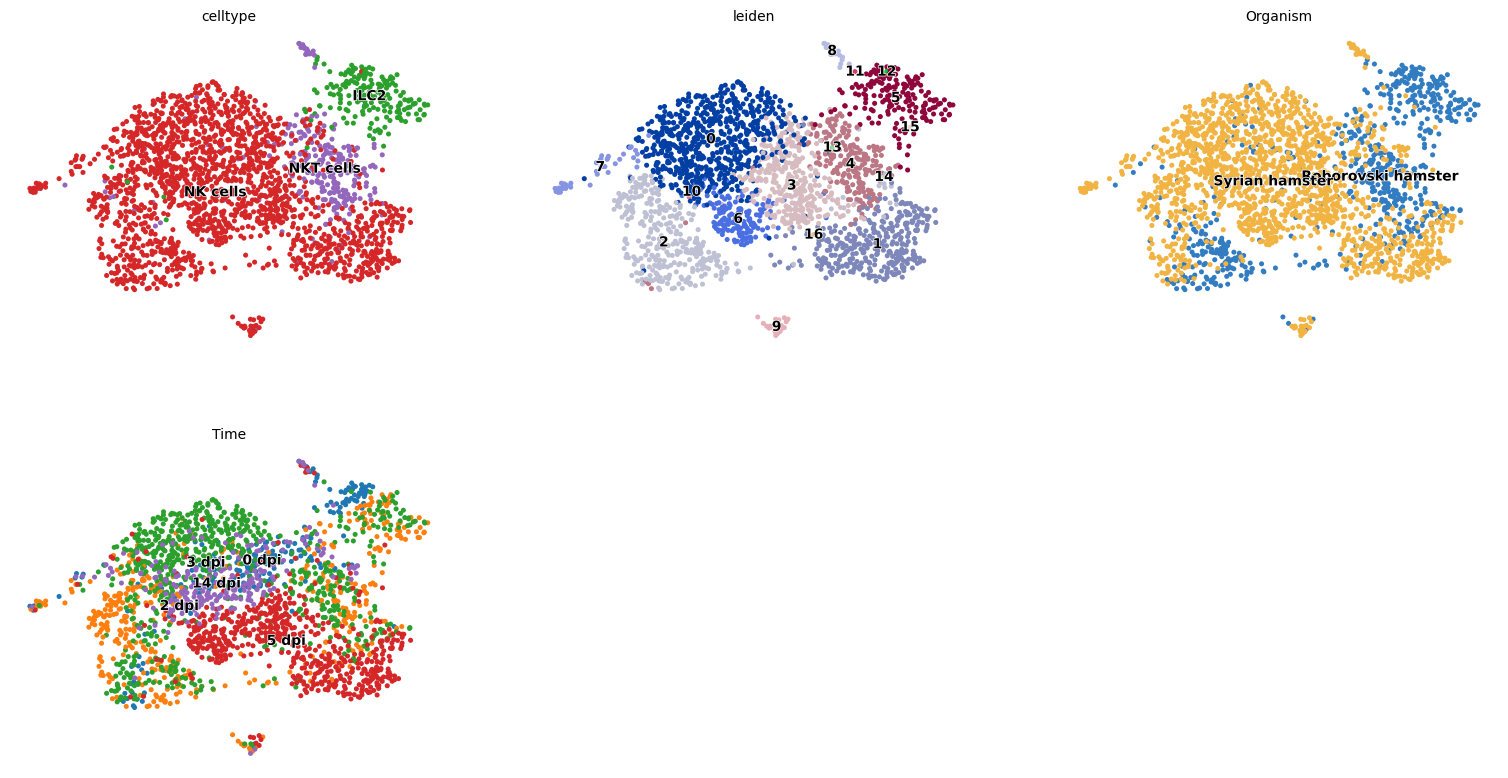

In [152]:
sc.tl.leiden(ndata, resolution=0.5, neighbors_key='neighbors_scVI')
scv.pl.scatter(ndata, basis='umap', legend_loc='on data', frameon=False, color=['celltype', 'leiden', 'Organism', 'Time'], ncols=3)

categories: 0, 1, 2, etc.
var_group_labels: NK cells, T cells


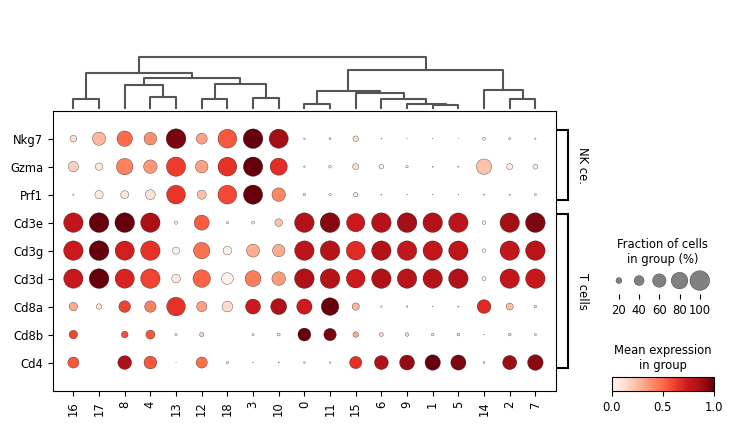

In [119]:
# NK markers
markers = {
    'NK cells': ['Nkg7', 'Gzma', 'Prf1'],
    'T cells': ['Cd3e', 'Cd3g', 'Cd3d', 'Cd8a', 'Cd8b', 'Cd4'],
}

sc.pl.dotplot(tdata, markers, groupby='leiden', use_raw=False, 
              dendrogram=True, standard_scale='var', swap_axes=True)

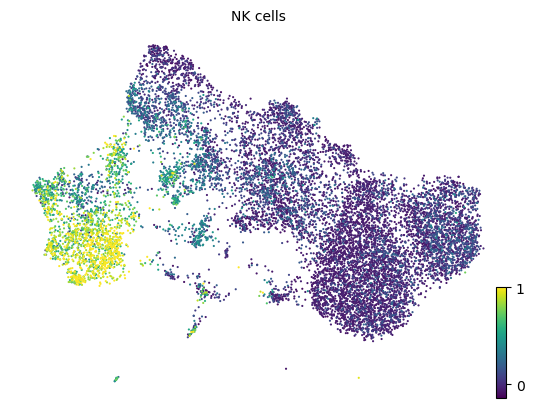

In [123]:
scv.pl.scatter(tdata, basis='umap_scVI', legend_loc='on data', frameon=False, color='NK cells', vmax=1)

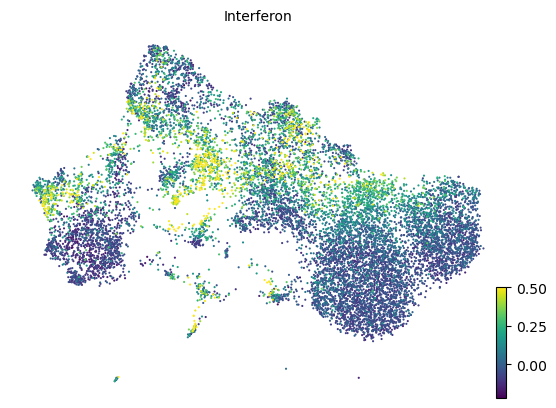

In [127]:
scv.pl.scatter(tdata, basis='umap_scVI', legend_loc='on data', frameon=False, color='Interferon', vmax=0.5)

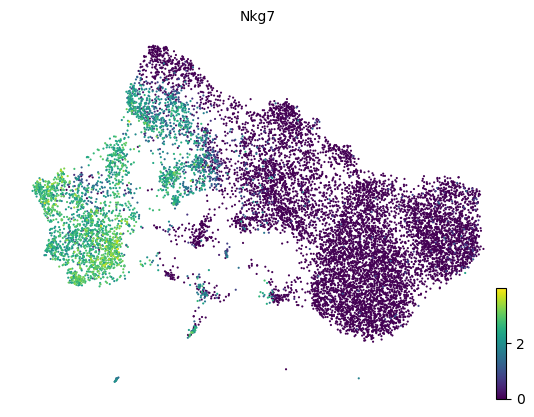

In [173]:
scv.pl.scatter(tdata, basis='umap_scVI', legend_loc='on data', frameon=False, color='Nkg7')

# Internal 16 / Rev2 6: Macro subtypes

Although not specifically highlighted, there is an unusual disproportionate distribution of lung macrophage populations (especially monocytic macrophages and alveolar macrophages) between the two hamster species. Given the role of macrophages in the resolution of inflammation (PMID: 31107246), can this difference be attributed to the differential pathophysiological response to SARS-CoV-2 has not been discussed upon in the manuscript.

In [5]:
mdata = sc.read_h5ad(data_path / "Cov19Hamster_timecourse_integrated_macrophages.h5")
mask = ~mdata.obs_names.isin(superdata.obs_names)
print(f"Removing {mask.sum()} cells from data")
mdata = mdata[~mask]
mdata.obs = superdata.obs.loc[mdata.obs_names].copy()
mdata = mdata[mdata.obs.celltype_rough.isin(['Macrophages'])].copy()
mdata.obs.celltype.cat.remove_unused_categories(inplace=True)
mdata.obs.celltype_rough.cat.remove_unused_categories(inplace=True)

Removing 353 cells from data


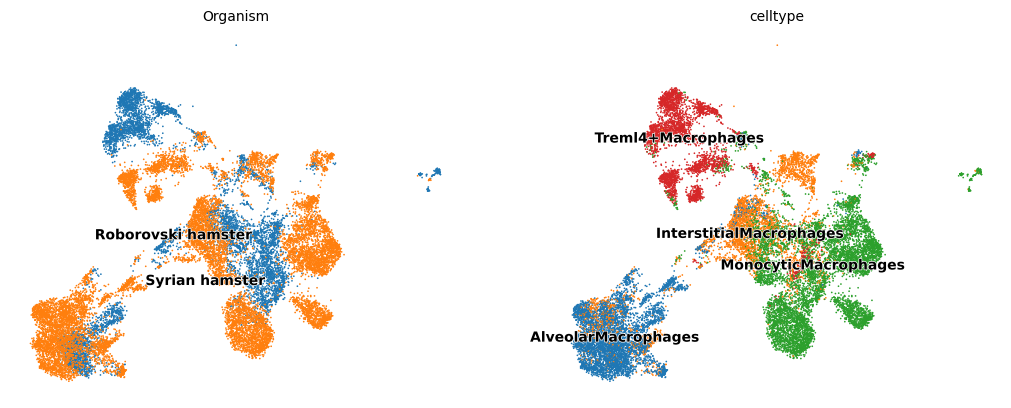

In [6]:
scv.pl.scatter(mdata, basis='umap_scVI', legend_loc='on data', frameon=False, color=['Organism', 'celltype'])

In [38]:
key = 'HALLMARK_INFLAMMATORY_RESPONSE'
# key = 'HALLMARK_INTERFERON_GAMMA_RESPONSE'

In [39]:
df = extract_df(mdata, ['celltype', 'Organism', 'Dosage', 'Time', 'replicate', key])

In [40]:
sdf = df.groupby(['celltype', 'Organism', 'Dosage', 'Time', 'replicate']).mean().reset_index().dropna()

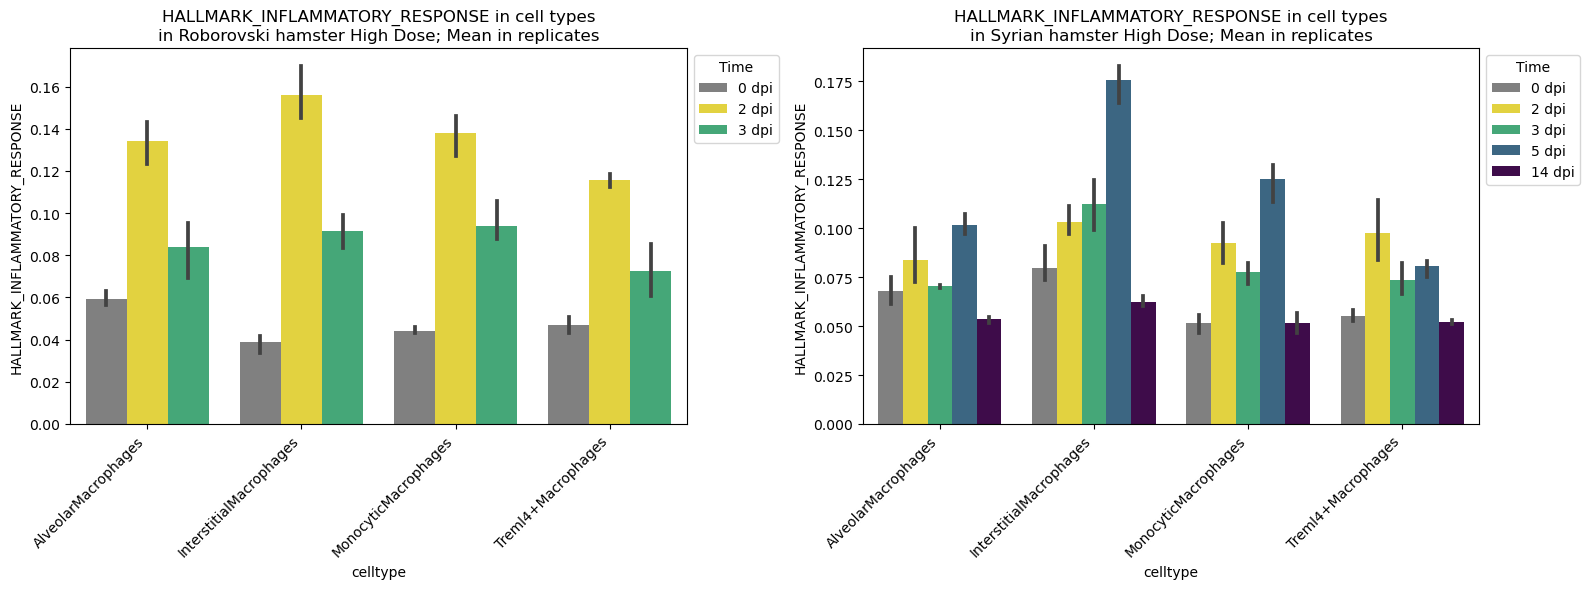

In [41]:
fig, axs = pl.subplots(1, 2, figsize=(8*2, 6))
for ax, Organism in zip(axs, ['Roborovski hamster', 'Syrian hamster']):
    data = sdf[(sdf.Organism == Organism) & (sdf.Dosage != '1x10$^4$ pfu')]
    data.Time = data.Time.cat.remove_unused_categories()
    sns.barplot(data=data, x='celltype', y=key, hue='Time', palette=Time_colors, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'{key} in cell types\nin {Organism} High Dose; Mean in replicates')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
pl.tight_layout()
pl.show()

In [53]:
# Cell Cycle
# df = extract_df(mdata, ['celltype', 'Organism', 'Dosage', 'Time', 'replicate', 'phase'])

## Diff Expression

In [7]:
# Let's try with pyDESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [8]:
# mdata[(mdata.obs.Organism=='Roborovski hamster') & (mdata.obs.Dosage!='1x10$^4$ pfu')]
# ['Time', '3 dpi', '0 dpi']
# "Time"
def run_deseq2(adata, design_factors, contrast,
               min_cells_per_group=10, min_counts=30, min_expressed=3,
               ):
    countData, colData = export_for_deseq(adata,
                                        keys=['celltype', 'Organism', 'Dosage', 'Time', 'replicate'], 
                                        layer='counts', min_cells_per_group=min_cells_per_group)
    countData = countData[countData.sum(1) >= min_counts]  # at least 10 counts in total
    countData = countData[(countData>0).sum(1) >= min_expressed]  # expressed in at least 3 samples
    print(countData.shape, colData.shape)

    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=countData.T,
        metadata=colData,
        design_factors=design_factors,
        refit_cooks=True,
        inference=inference,
        quiet=True
    )
    dds.deseq2()
    stat_res = DeseqStats(dds, inference=inference, quiet=True, contrast=contrast)
    stat_res.summary()  # Run the statistical analysis.
    stat_res.lfc_shrink();  # Shrink the log2 fold changes.
    
    df = stat_res.results_df.sort_values('log2FoldChange')
    df['neglog10_padj'] = -np.log10(df['padj'])
    return df

In [9]:
# Run deseq2 per organism_dosage
mask = (mdata.obs.celltype=='InterstitialMacrophages')

robo_hd_df = run_deseq2(mdata[(mdata.obs.Organism=='Roborovski hamster') & (mdata.obs.Dosage != '1x10$^4$ pfu') & mask],
           design_factors="Time",
           contrast=['Time', '3 dpi', '0 dpi']
          )

robo_ld_df = run_deseq2(mdata[(mdata.obs.Organism=='Roborovski hamster') & (mdata.obs.Dosage != '1x10$^5$ pfu') & mask],
           design_factors="Time",
           contrast=['Time', '3 dpi', '0 dpi']
          )

syrian_df = run_deseq2(mdata[(mdata.obs.Organism=='Syrian hamster') & mask],
           design_factors="Time",
           contrast=['Time', '3 dpi', '0 dpi']
          )

0it [00:00, ?it/s]

(9147, 9) (9, 6)
Log2 fold change & Wald test p-value: Time 3 dpi vs 0 dpi
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610010F05Rik        4.228549       -1.087458  0.883387 -1.231010  0.218319   
0610010K14Rik       13.642612        0.094582  0.609091  0.155284  0.876597   
0610012G03Rik       65.585402        0.722204  0.317916  2.271683  0.023106   
1110004F10Rik      173.610036        0.082171  0.232495  0.353430  0.723766   
1110008P14Rik      199.703768        0.801447  0.276015  2.903636  0.003689   
...                       ...             ...       ...       ...       ...   
unknown_gene_8977   21.329710       -0.024058  0.473206 -0.050840  0.959453   
unknown_gene_9043    3.275687        1.230972  1.511779  0.814254  0.415499   
unknown_gene_9109   11.393251       -1.179649  0.570353 -2.068280  0.038614   
unknown_gene_9131  293.143798       -1.087371  0.239588 -4.538496  0.000006   
unknown_gene_9840  100.949190       -0.141643  0.279308 

0it [00:00, ?it/s]

(8168, 9) (9, 6)
Log2 fold change & Wald test p-value: Time 3 dpi vs 0 dpi
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610010F05Rik        3.187336       -0.353329  1.061388 -0.332893  0.739215   
0610010K14Rik        6.403940        0.537968  0.814587  0.660418  0.508986   
0610012G03Rik       28.878573        0.452679  0.408266  1.108784  0.267524   
1110004F10Rik       68.494633       -0.181433  0.265952 -0.682204  0.495110   
1110008P14Rik       77.428720        0.693576  0.311013  2.230052  0.025744   
...                       ...             ...       ...       ...       ...   
unknown_gene_8571   14.938327       -0.543526  0.524013 -1.037237  0.299625   
unknown_gene_8977    8.557330       -0.976829  0.666341 -1.465960  0.142659   
unknown_gene_9109    9.514930        0.129392  0.681470  0.189872  0.849409   
unknown_gene_9131  190.740184       -0.262032  0.310177 -0.844785  0.398231   
unknown_gene_9840   45.986716        0.121993  0.346266 

0it [00:00, ?it/s]

(12294, 15) (15, 6)
Log2 fold change & Wald test p-value: Time 3 dpi vs 0 dpi
                                baseMean  log2FoldChange     lfcSE      stat  \
A4galt                        195.660291        0.269005  0.168573  1.595776   
ATP6                            8.074337        0.369360  0.632818  0.583676   
Aaas                           17.185918        0.366807  0.461351  0.795071   
Aacs                           31.784844       -0.398563  0.311641 -1.278920   
Aagab                          31.878841       -0.098168  0.312671 -0.313966   
...                                  ...             ...       ...       ...   
Zzz3                           19.893365       -0.583768  0.364633 -1.600976   
rna-NC_013276.1:1101..2662    996.779556        1.376117  0.204937  6.714835   
rna-NC_013276.1:11528..11594    3.664971        0.945063  1.278484  0.739206   
rna-NC_013276.1:11596..11653    3.299956        0.655990  0.958871  0.684127   
rna-NC_013276.1:14052..14120    2.672126  

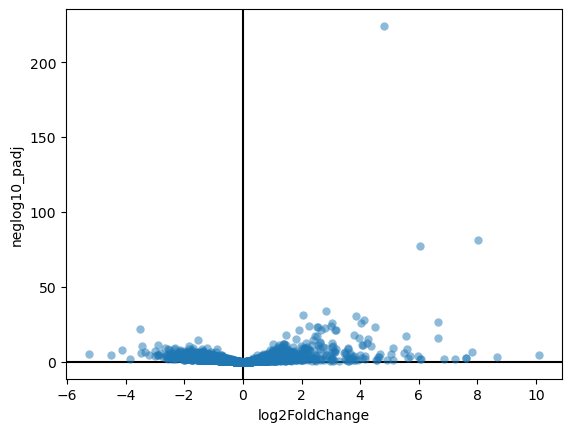

In [10]:
sns.scatterplot(data=robo_hd_df, x='log2FoldChange', y='neglog10_padj', edgecolor=None, linewidth=0, alpha=0.5)
pl.axvline(0, color='k', linestyle='-', zorder=0)
pl.axhline(0, color='k', linestyle='-', zorder=0)
pl.show()

In [11]:
df = pd.concat({'Roborovski hamster HD': robo_hd_df, 'Syrian hamster': syrian_df, 'Roborovski hamster LD': robo_ld_df}, axis=1, names=['Organism']).dropna()
df.shape

(6060, 21)

In [12]:
df.head()

Organism Roborovski hamster HD                                     \
                      baseMean log2FoldChange     lfcSE      stat   
Fbp1                 48.014607      -5.261929  1.156327 -5.212585   
Enpp5                21.767894      -3.460494  0.685870 -5.617238   
Aspm                 32.226589      -2.929314  0.682576 -4.926041   
Mgam                 85.791875      -2.661393  0.416161 -6.821901   
Rasgef1b              6.821522      -2.625061  0.865669 -3.823086   

Organism                                           Syrian hamster  \
                pvalue          padj neglog10_padj       baseMean   
Fbp1      1.862269e-07  7.555364e-06      5.121745      77.843597   
Enpp5     1.940339e-08  1.017613e-06      5.992417      15.249806   
Aspm      8.391260e-07  2.643708e-05      4.577787      13.519184   
Mgam      8.984376e-12  1.072463e-09      8.969618      29.566813   
Rasgef1b  1.317915e-04  1.771155e-03      2.751744      93.734193   

Organism                           ...                                    \
         log2FoldChange     lfcSE  ...    pvalue      padj neglog10_padj   
Fbp1          -0.006014  0.231945  ...  0.946441  0.977888      0.009711   
Enpp5          0.083620  0.209076  ...  0.618979  0.817334      0.087601   
Aspm           0.301665  0.364220  ...  0.023132  0.116944      0.932024   
Mgam           1.295370  1.522063  ...  0.005952  0.044140      1.355168   
Rasgef1b       0.135131  0.183990  ...  0.420340  0.677798      0.168900   

Organism Roborovski hamster LD                                     \
                      baseMean log2FoldChange     lfcSE      stat   
Fbp1                 29.956941      -0.102592  0.441098 -1.126632   
Enpp5                13.357097      -0.931458  0.824613 -2.466096   
Aspm                 17.071631      -0.348609  0.628055 -2.205187   
Mgam                 49.600588      -1.535722  0.340502 -5.016497   
Rasgef1b              5.757805      -0.138800  0.406285 -0.776019   

Organism                                        
                pvalue      padj neglog10_padj  
Fbp1      2.598981e-01  0.595290      0.225272  
Enpp5     1.365947e-02  0.110310      0.957384  
Aspm      2.744100e-02  0.172364      0.763553  
Mgam      5.262213e-07  0.000041      4.385768  
Rasgef1b  4.377376e-01  0.741449      0.129919  

[5 rows x 21 columns]

In [35]:
hallmark_ifn_genes = ['STAT1', 'ISG15', 'IFIT1', 'MX1', 'IFIT3', 'IFI35', 'IRF7', 'IFIT2', 'OAS2', 'TAP1', 'EIF2AK2', 'RSAD2', 'MX2', 'IRF1', 'OAS3', 'TNFSF10', 'IRF9', 'CXCL10', 'IFI44', 'BST2', 'XAF1', 'SP110', 'OASL', 'PSMB8', 'IFI44L', 'IFITM3', 'DDX60', 'LGALS3BP', 'GBP4', 'IRF8', 'PSMB9', 'PML', 'IFIH1', 'UBE2L6', 'IFI27', 'ADAR', 'LY6E', 'STAT2', 'CXCL9', 'IL10RA', 'PLA2G4A', 'TRIM21', 'USP18', 'PTGS2', 'EPSTI1', 'C1S', 'DDX58', 'IL15', 'NLRC5', 'NMI', 'IDO1', 'PSMB10', 'CXCL11', 'ITGB7', 'SAMHD1', 'HERC6', 'CMPK2', 'SAMD9L', 'RTP4', 'PTPN2', 'PARP14', 'TNFAIP2', 'IFITM2', 'PLSCR1', 'SOCS1', 'CASP1', 'ICAM1', 'WARS', 'PSME1', 'ISG20', 'IRF2', 'TRIM14', 'FCGR1A', 'MARCH1', 'SOCS3', 'JAK2', 'HLA-DMA', 'PARP12', 'TNFAIP6', 'TRIM26', 'VCAM1', 'CD274', 'CIITA', 'NAMPT', 'SELP', 'GPR18', 'FPR1', 'PRIC285', 'PSME2', 'SERPING1', 'CCL5', 'RNF31', 'SOD2', 'TRIM25', 'LAP3', 'PSMA3', 'RNF213', 'PELI1', 'CFB', 'CD86', 'TXNIP', 'HLA-DQA1', 'GCH1', 'PNP', 'CCL7', 'PTPN6', 'SPPL2A', 'IL4R', 'PNPT1', 'DHX58', 'BTG1', 'CASP8', 'IFI30', 'CCL2', 'FGL2', 'CASP7', 'SECTM1', 'IL15RA', 'CD40', 'TRAFD1', 'HLA-DRB1', 'GBP6', 'LCP2', 'HLA-G', 'MT2A', 'RIPK1', 'KLRK1', 'UPP1', 'PSMB2', 'TDRD7', 'HIF1A', 'EIF4E3', 'VAMP8', 'PFKP', 'CD38', 'ZBP1', 'BANK1', 'TOR1B', 'RBCK1', 'PDE4B', 'MVP', 'IL7', 'BPGM', 'FTSJD2', 'AUTS2', 'B2M', 'RIPK2', 'CD69', 'MYD88', 'PSMA2', 'PIM1', 'NOD1', 'CFH', 'TAPBP', 'SLC25A28', 'PTPN1', 'TNFAIP3', 'SSPN', 'NUP93', 'MTHFD2', 'CDKN1A', 'IRF4', 'NFKB1', 'BATF2', 'HLA-B', 'LATS2', 'IRF5', 'SLAMF7', 'ISOC1', 'P2RY14', 'STAT3', 'NCOA3', 'HLA-A', 'IL6', 'GZMA', 'IFNAR2', 'CD74', 'RAPGEF6', 'CASP4', 'FAS', 'OGFR', 'ARL4A', 'SRI', 'LYSMD2', 'CSF2RB', 'ST3GAL5', 'C1R', 'CASP3', 'CMKLR1', 'NFKBIA', 'METTL7B', 'ST8SIA4', 'XCL1', 'IL2RB', 'VAMP5', 'IL18BP', 'ZNFX1', 'ARID5B', 'APOL6', 'STAT4']
hallmark_ifn_genes = specify_genes(hallmark_ifn_genes, 'human', 'mouse')
sdf = df['Roborovski hamster HD'].copy()
sdf['ifn_gene'] = 'False'
sdf.loc[np.intersect1d(sdf.index, hallmark_ifn_genes), 'ifn_gene'] = 'True'

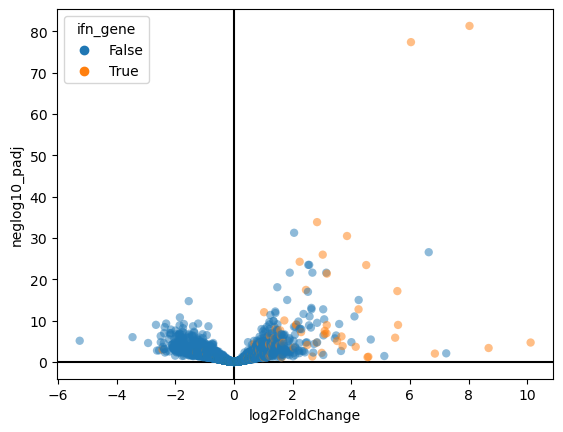

In [38]:
sns.scatterplot(data=sdf, x='log2FoldChange', y='neglog10_padj', edgecolor=None, linewidth=0, alpha=0.5, hue='ifn_gene')
pl.axvline(0, color='k', linestyle='-', zorder=0)
pl.axhline(0, color='k', linestyle='-', zorder=0)
pl.show()

<Axes: xlabel='ifn_gene', ylabel='log2FoldChange'>

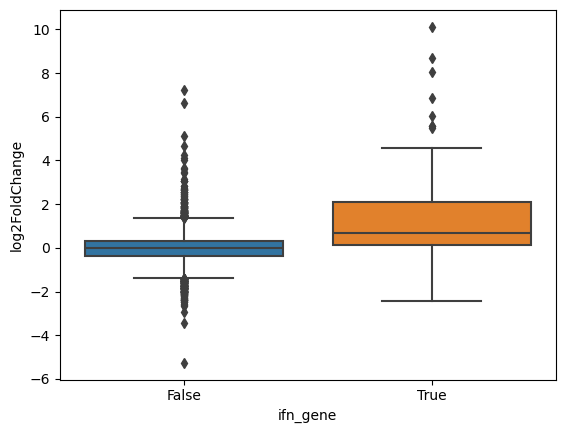

In [28]:
sns.boxplot(data=sdf, x='ifn_gene', y='log2FoldChange')

In [41]:
sdf['log_baseMean'] = np.log(sdf['baseMean'])

<Axes: xlabel='log2FoldChange', ylabel='log_baseMean'>

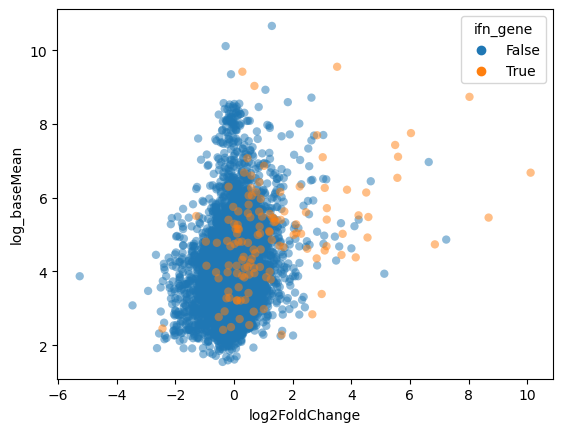

In [45]:
sns.scatterplot(data=sdf.sort_values('ifn_gene'), x='log2FoldChange', y='log_baseMean', edgecolor=None, linewidth=0, alpha=0.5, hue='ifn_gene')

<Axes: xlabel='ifn_gene', ylabel='baseMean'>

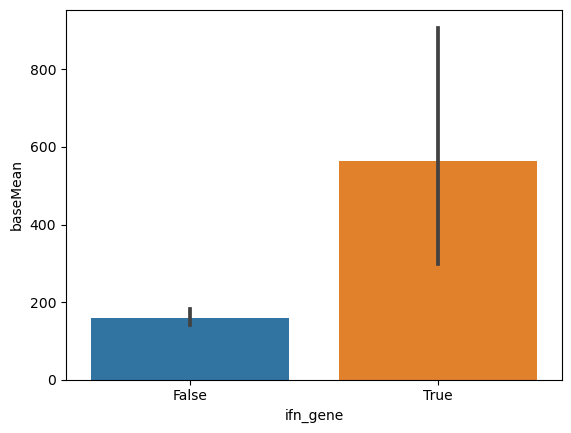

In [32]:
# Unfair comparison
sns.barplot(data=sdf, x='ifn_gene', y='baseMean')

## E-distance

In [47]:
from scperturb import edist, edist_to_control

In [ ]:
# E-distances
estats = edist(mdata, obs_key='O')

In [ ]:

# E-distances to a specific group (e.g. 'control')
estats_control = estats.loc['control']
# E-test for difference to control
df = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', control='control', alpha=0.05, runs=100)

## Macro Diffmap

In [44]:
sc.pp.neighbors(mdata, use_rep='X_scVI')
sc.tl.diffmap(mdata)

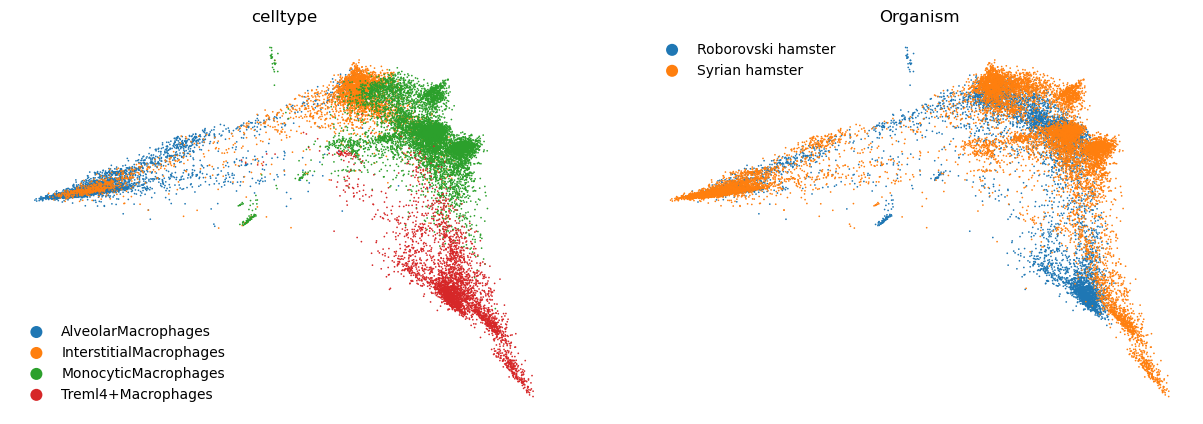

In [56]:
sc.pl.scatter(mdata, basis='diffmap', color=['celltype', 'Organism'], frameon=False, legend_loc='best', components='2,3')

## Virus

In [57]:
df = extract_df(mdata, ['celltype', 'Organism', 'Dosage', 'Time', 'replicate', 'SCoV2_sum', 'SCoV2_load', 'SCoV2_detected'])

In [63]:
df.SCoV2_detected = df.SCoV2_detected.astype('int')
sdf = df.groupby(['celltype', 'Organism', 'Dosage', 'Time', 'replicate']).mean().reset_index().dropna()

In [64]:
sdf

celltype            Organism        Dosage    Time replicate  \
0    AlveolarMacrophages  Roborovski hamster         0 pfu   0 dpi         1   
1    AlveolarMacrophages  Roborovski hamster         0 pfu   0 dpi         2   
2    AlveolarMacrophages  Roborovski hamster         0 pfu   0 dpi         3   
18   AlveolarMacrophages  Roborovski hamster  1x10$^4$ pfu   2 dpi         1   
19   AlveolarMacrophages  Roborovski hamster  1x10$^4$ pfu   2 dpi         2   
..                   ...                 ...           ...     ...       ...   
355   Treml4+Macrophages      Syrian hamster  1x10$^5$ pfu   5 dpi         2   
356   Treml4+Macrophages      Syrian hamster  1x10$^5$ pfu   5 dpi         3   
357   Treml4+Macrophages      Syrian hamster  1x10$^5$ pfu  14 dpi         1   
358   Treml4+Macrophages      Syrian hamster  1x10$^5$ pfu  14 dpi         2   
359   Treml4+Macrophages      Syrian hamster  1x10$^5$ pfu  14 dpi         3   

     SCoV2_sum  SCoV2_load  SCoV2_detected  
0     0.000000    0.000000        0.000000  
1     0.000000    0.000000        0.000000  
2     0.000000    0.000000        0.000000  
18    0.030075    0.000224        0.030075  
19    0.000000    0.000000        0.000000  
..         ...         ...             ...  
355   0.029126    0.000433        0.029126  
356   0.012658    0.000166        0.012658  
357   0.000000    0.000000        0.000000  
358   0.000000    0.000000        0.000000  
359   0.000000    0.000000        0.000000  

[120 rows x 8 columns]

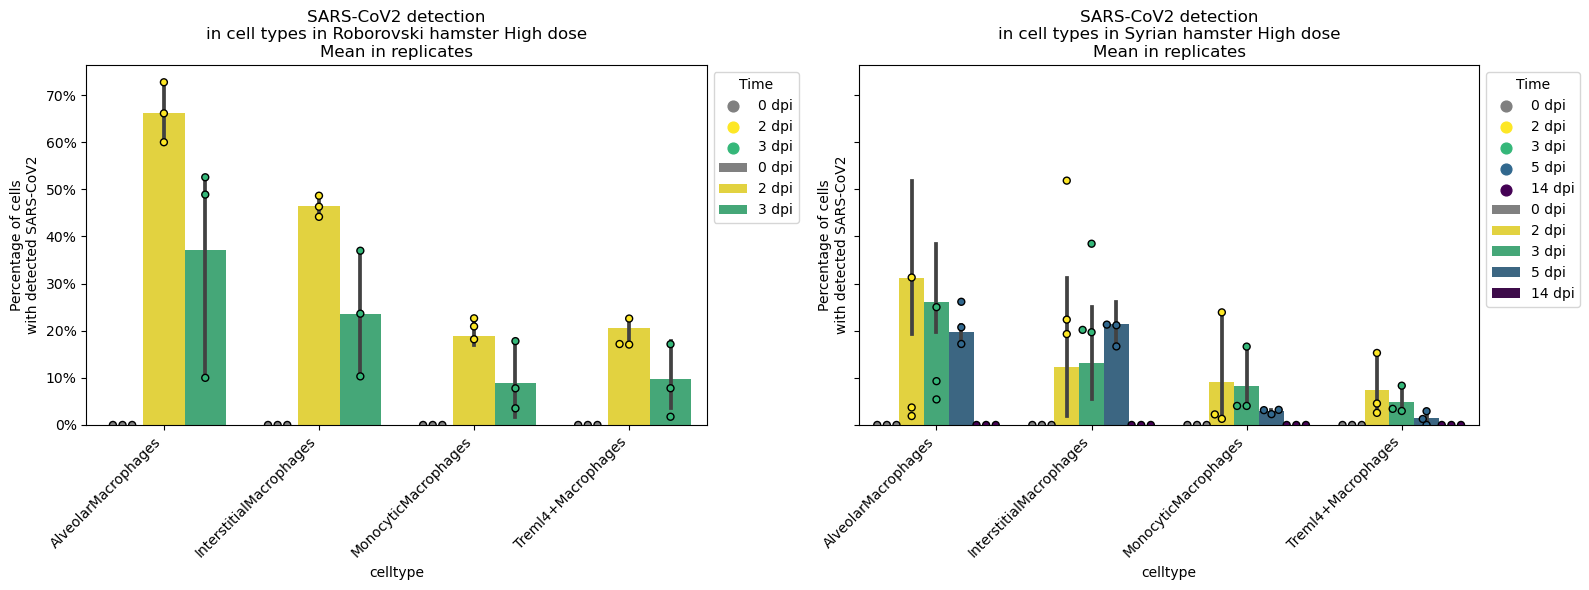

In [78]:
fig, axs = pl.subplots(1, 2, figsize=(8*2, 6), sharex=False, sharey=True)
for Organism, ax in zip(['Roborovski hamster', 'Syrian hamster'], axs):
    data = sdf[(sdf.Organism == Organism) & (sdf.Dosage != '1x10$^4$ pfu')]
    per_celltype_stats = data.groupby(['celltype']).median().sort_values('SCoV2_detected', ascending=False)
    order = per_celltype_stats.index
    order = order[order.isin(data.celltype.unique())]
    data.Time.cat.remove_unused_categories(inplace=True)
    sns.barplot(data=data, x='celltype', y='SCoV2_detected', hue='Time', palette=Time_colors, ax=ax, order=order)
    sns.swarmplot(data=data, x='celltype', y='SCoV2_detected', hue='Time', palette=Time_colors, ax=ax, dodge=True, alpha=1, edgecolor='k', linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'SARS-CoV2 detection\nin cell types in {Organism} High dose\nMean in replicates')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_ylabel('Percentage of cells\nwith detected SARS-CoV2')
    ax.yaxis.set_major_formatter(pl.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pl.tight_layout()
pl.show()

## ISGs

In [74]:
ams_genes = 'Mnda,Isg15,Mx1,Samhd1,Ifit3,Nmi,Apobec1,Samd9,Lgals9,Psme1,Herc6,Ifit2,Irf7,Lgals3bp,Parp9,Ly6e'.split(',')

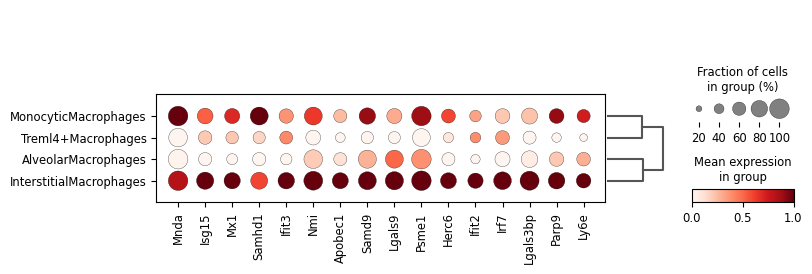

In [77]:
sc.pl.dotplot(mdata, ams_genes, groupby='celltype', use_raw=False, dendrogram=True, standard_scale='var', swap_axes=False)


In [118]:
# get l2fc for these genes
# pseudo-bulk first, fc w.r.t. 0 dpi in each organism
df = extract_df(mdata, ['celltype', 'Organism', 'Dosage', 'Time', 'replicate'] + ams_genes)
df = df[df.Dosage != '1x10$^4$ pfu']
sdf = df.groupby(['celltype', 'Organism', 'Dosage', 'Time', 'replicate']).mean().reset_index().dropna()

In [119]:
# now l2fc
baseline_mean = sdf[sdf.Time=='0 dpi'].groupby(['celltype', 'Organism']).mean()
fcs = {}
for celltype in sdf.celltype.unique():
    for organism in sdf.Organism.unique():
        fcs[(celltype, organism)] = sdf[(sdf.celltype==celltype) & (sdf.Organism==organism)].mean() / baseline_mean.loc[celltype, organism]

In [120]:
res = pd.concat(fcs, axis=0).reset_index().rename(columns={'level_0': 'celltype', 'level_1': 'Organism'})
# make celltype and organism to index, and level_2 to columns
res = pd.pivot_table(res, index=['celltype', 'Organism'], columns='level_2', values=0)
res = np.log2(res)
# remove infty values
res = res.replace([np.inf, -np.inf], np.nan)
res

level_2                                      Apobec1     Herc6     Ifit2  \
celltype                Organism                                           
AlveolarMacrophages     Roborovski hamster  3.187839  2.729977  5.107299   
                        Syrian hamster      1.630736  1.234517  2.084900   
InterstitialMacrophages Roborovski hamster  4.084793  4.188266  5.012797   
                        Syrian hamster      2.185298  2.182166  3.002345   
MonocyticMacrophages    Roborovski hamster  6.076600  4.106606  5.402416   
                        Syrian hamster      4.346611  3.190726  6.355544   
Treml4+Macrophages      Roborovski hamster  8.607229  4.730216  4.217606   
                        Syrian hamster      5.211168  2.687369  6.148441   

level_2                                        Ifit3      Irf7     Isg15  \
celltype                Organism                                           
AlveolarMacrophages     Roborovski hamster  5.345352  3.530824  5.924409   
                        Syrian hamster      2.107977  1.554620  1.847956   
InterstitialMacrophages Roborovski hamster  5.463865  4.179618  5.040325   
                        Syrian hamster      2.648715  1.936232  2.516252   
MonocyticMacrophages    Roborovski hamster  4.825648  4.279885  4.323330   
                        Syrian hamster      4.495546  3.712750  4.922627   
Treml4+Macrophages      Roborovski hamster  3.862289  6.009683  4.150222   
                        Syrian hamster      4.652883  4.586208  8.527892   

level_2                                     Lgals3bp    Lgals9      Ly6e  \
celltype                Organism                                           
AlveolarMacrophages     Roborovski hamster  2.074922  1.043089  4.608399   
                        Syrian hamster      1.252686  0.751837  0.928049   
InterstitialMacrophages Roborovski hamster  1.811590  2.090278       NaN   
                        Syrian hamster      0.839547  0.968055  1.493263   
MonocyticMacrophages    Roborovski hamster  1.757597  2.196850  2.844738   
                        Syrian hamster      2.266234  3.171163  2.741874   
Treml4+Macrophages      Roborovski hamster  3.855442  4.192812  3.534299   
                        Syrian hamster      2.182019  1.695200  3.257203   

level_2                                         Mnda       Mx1       Nmi  \
celltype                Organism                                           
AlveolarMacrophages     Roborovski hamster  0.125561  3.406173  1.207742   
                        Syrian hamster      0.498848  2.180120  0.612834   
InterstitialMacrophages Roborovski hamster  0.224834  2.762978  1.501721   
                        Syrian hamster      0.771847  2.456552  0.971175   
MonocyticMacrophages    Roborovski hamster  0.222794  3.474154  1.360672   
                        Syrian hamster      0.615693  4.626868  1.315998   
Treml4+Macrophages      Roborovski hamster  0.654217  3.291158  1.618551   
                        Syrian hamster      1.038387  2.529709  1.285904   

level_2                                        Parp9     Psme1     Samd9  \
celltype                Organism                                           
AlveolarMacrophages     Roborovski hamster  0.923606  0.557270  0.906885   
                        Syrian hamster      0.866311  0.482310  0.308367   
InterstitialMacrophages Roborovski hamster  1.311111  0.537576  0.615855   
                        Syrian hamster      1.134653  0.500348  0.713515   
MonocyticMacrophages    Roborovski hamster  1.702581  0.605744  1.002058   
                        Syrian hamster      1.908699  0.625271  1.681378   
Treml4+Macrophages      Roborovski hamster  2.241425  0.397206  1.317184   
                        Syrian hamster      2.249989  0.621472  5.124592   

level_2                                       Samhd1  
celltype                Organism                      
AlveolarMacrophages     Roborovski hamster  0.124415  
                        Syrian

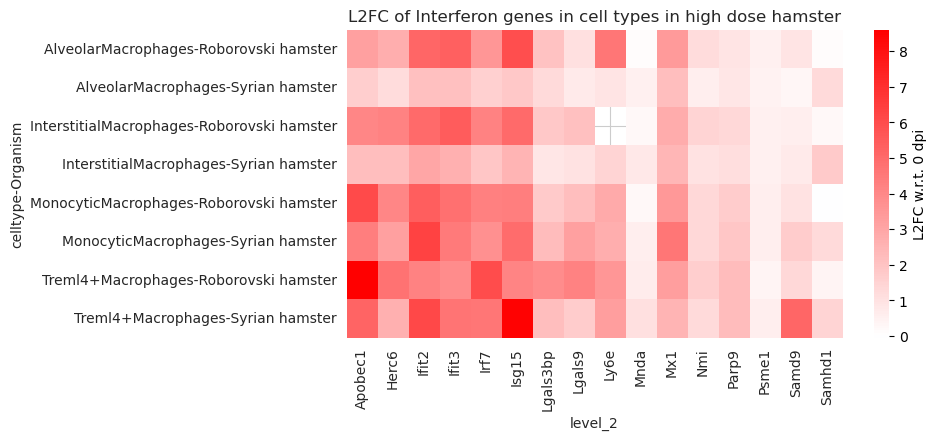

In [125]:
# heatmap
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8, 4))
sns.heatmap(res, cmap='bwr', center=0, ax=ax)
# add colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('L2FC w.r.t. 0 dpi')
pl.title('L2FC of Interferon genes in cell types in high dose hamster')
pl.show()

# Internal 17 / Rev2 7: species-specific comparison of uncontrolled cell death, particularly in AT2 cells

Figure S3 A, shows only Roborovski hamster infected with highest dose of SARS-CoV-2 have overall dramatic elevation in the levels of Il6 as early as day 2 post infection. As Il6 is one of the earliest markers of inflammation inflicted by damaged tissue (due to infection), a species-specific comparison of uncontrolled cell death can be performed. Did the do any of the cell types, particularly the AT2 cells, appear to have cell death programs associated with them? Also, is there any evidence of macrophages ingesting AT2/AT1 cells associated with these cells dying?

- Markers to focus on: IL6
- Select some cell death signatures
- Compare to across species, maybe also with human
- Focus on Epithelial cells
- Doublets Macros x Epithelial

- HALLMARK_APOPTOSIS
- KEGG_APOPTOSIS
- I think they are looking for *uncontrolled* cell death. I should try to differentiate between the cell death types. Importantly, I should differentiate between 
    - apoptosis
    - immunogenic cell death
    - pyroptosis

In [ ]:
cell_death_markers = {
    'Hallmark_apoptosis': ['ADD1', 'AIFM3', 'ANKH', 'ANXA1', 'APP', 'ATF3', 'AVPR1A', 'BAX', 'BCAP31', 'BCL10', 'BCL2L1', 'BCL2L10', 'BCL2L11', 'BCL2L2', 'BGN', 'BID', 'BIK', 'BIRC3', 'BMF', 'BMP2', 'BNIP3L', 'BRCA1', 'BTG2', 'BTG3', 'CASP1', 'CASP2', 'CASP3', 'CASP4', 'CASP6', 'CASP7', 'CASP8', 'CASP9', 'CAV1', 'CCNA1', 'CCND1', 'CCND2', 'CD14', 'CD2', 'CD38', 'CD44', 'CD69', 'CDC25B', 'CDK2', 'CDKN1A', 'CDKN1B', 'CFLAR', 'CLU', 'CREBBP', 'CTH', 'CTNNB1', 'CYLD', 'DAP', 'DAP3', 'DCN', 'DDIT3', 'DFFA', 'DIABLO', 'DNAJA1', 'DNAJC3', 'DNM1L', 'DPYD', 'EBP', 'EGR3', 'EMP1', 'ENO2', 'ERBB2', 'ERBB3', 'EREG', 'ETF1', 'F2', 'F2R', 'FAS', 'FASLG', 'FDXR', 'FEZ1', 'GADD45A', 'GADD45B', 'GCH1', 'GNA15', 'GPX1', 'GPX3', 'GPX4', 'GSN', 'GSR', 'GSTM1', 'GUCY2D', 'H1-0', 'HGF', 'HMGB2', 'HMOX1', 'HSPB1', 'IER3', 'IFITM3', 'IFNB1', 'IFNGR1', 'IGF2R', 'IGFBP6', 'IL18', 'IL1A', 'IL1B', 'IL6', 'IRF1', 'ISG20', 'JUN', 'KRT18', 'LEF1', 'LGALS3', 'LMNA', 'PLPPR4', 'LUM', 'MADD', 'MCL1', 'MGMT', 'MMP2', 'NEDD9', 'NEFH', 'PAK1', 'PDCD4', 'PDGFRB', 'PEA15', 'PLAT', 'PLCB2', 'PMAIP1', 'PPP2R5B', 'PPP3R1', 'PPT1', 'PRF1', 'PSEN1', 'PSEN2', 'PTK2', 'RARA', 'RELA', 'RETSAT', 'RHOB', 'RHOT2', 'RNASEL', 'ROCK1', 'SAT1', 'SATB1', 'SC5D', 'SLC20A1', 'SMAD7', 'SOD1', 'SOD2', 'SPTAN1', 'SQSTM1', 'TAP1', 'TGFB2', 'TGFBR3', 'TIMP1', 'TIMP2', 'TIMP3', 'TNF', 'TNFRSF12A', 'TNFSF10', 'TOP2A', 'TSPO', 'TXNIP', 'VDAC2', 'WEE1', 'XIAP'],
    'Hallmark_inflammatory_response': ['CXCL10', 'CCL2', 'CCL5', 'FPR1', 'CCL20', 'IL1A', 'IL8', 'CCL7', 'CCL22', 'CXCL11', 'CCR7', 'EDN1', 'CD40', 'CXCL9', 'IL6', 'IL1B', 'TLR2', 'IL1R1', 'CD69', 'ICAM1', 'CCRL2', 'AQP9', 'EREG', 'C3AR1', 'GNA15', 'CMKLR1', 'PTGER4', 'LIF', 'IL15', 'NAMPT', 'OPRK1', 'ITGB8', 'PTAFR', 'ADM', 'PLAUR', 'NFKB1', 'INHBA', 'OSM', 'TNFSF10', 'TNFSF15', 'IFNGR2', 'EMR1', 'IL12B', 'CSF1', 'CXCL6', 'TNFRSF9', 'LYN', 'ACVR2A', 'LDLR', 'BDKRB1', 'HRH1', 'F3', 'BST2', 'PTGIR', 'CD55', 'CALCRL', 'CSF3', 'GPR132', 'IL4R', 'NLRP3', 'IL15RA', 'ADORA2B', 'GCH1', 'OLR1', 'PTGER2', 'CSF3R', 'MYC', 'RELA', 'TNFAIP6', 'IL7R', 'IL18', 'GABBR1', 'CD82', 'TNFSF9', 'NMUR1', 'IL2RB', 'TLR1', 'LPAR1', 'IRAK2', 'RIPK2', 'MMP14', 'P2RX7', 'SLC11A2', 'SELL', 'P2RY2', 'ABCA1', 'FFAR2', 'PROK2', 'GNAI3', 'TACR1', 'SLC7A1', 'CDKN1A', 'CYBB', 'TIMP1', 'HBEGF', 'SCARF1', 'EBI3', 'NFKBIA', 'SRI', 'SLC7A2', 'CCL17', 'TLR3', 'APLNR', 'OSMR', 'IL10RA', 'PSEN1', 'GPR183', 'ATP2B1', 'TNFRSF1B', 'BEST1', 'GPC3', 'SCN1B', 'ACVR1B', 'HPN', 'SEMA4D', 'KLF6', 'CD48', 'CXCR6', 'SLC1A2', 'GP1BA', 'TAPBP', 'RGS16', 'SLAMF1', 'LCK', 'HIF1A', 'AHR', 'NMI', 'RHOG', 'TPBG', 'NPFFR2', 'IFNAR1', 'ICOSLG', 'RASGRP1', 'IFITM1', 'KCNJ2', 'LY6E', 'IL18R1', 'IL10', 'KCNA3', 'HAS2', 'DCBLD2', 'LAMP3', 'VIP', 'CD70', 'RGS1', 'SLC31A1', 'ADRM1', 'KCNMB2', 'SERPINE1', 'MXD1', 'AXL', 'MEFV', 'PVR', 'CCL24', 'PDE4B', 'LCP2', 'PDPN', 'IRF7', 'MET', 'ATP2A2', 'SLC31A2', 'FZD5', 'ITGA5', 'SGMS2', 'MARCO', 'CD14', 'EIF2AK2', 'ROS1', 'ATP2C1', 'NDP', 'BTG2', 'MSR1', 'PTPRE', 'RNF144B', 'PCDH7', 'SPHK1', 'IL18RAP', 'RTP4', 'RAF1', 'CHST2', 'ITGB3', 'KIF1B', 'SELE', 'NOD2', 'C5AR1', 'EMP3', 'CLEC5A', 'TACR3', 'SLC4A4', 'MEP1A', 'SELS', 'LTA', 'PIK3R5', 'STAB1', 'IRF1', 'ICAM4', 'P2RX4', 'ABI1', 'CX3CL1', 'SLC28A2'],
    'cherry_apoptosis': ['Anxa1', 'Bax', 'Atf3', 'Bcl10', 'Birc3', 'Casp1', 'Casp3', 'Casp7', 'Casp8', 'Cdkn1a', 'Ddit3', 'Hmgb2', 'Fas', 'Gch1', 'Ier3', 'Ifngr1', 'Il18', 'Il16', 'Il1a', 'Il1b', 'Il6', 'Irf1', 'Jun', 'Mcl1', 'Timp1', 'Tnfsf10', 'Calr', 'Irf2', 'Nod2', 'Tlr2'],
    'ICD': ['CALR', 'HMGB1', 'ATP', 'ANXA1', 'IFNA1'],
    'pyroptosis': ['CASP1', 'CASP4', 'TLR2', 'IL18', 'IL1B', 'GSDMD', 'IL1A', 'GSDMA', 'TP53', 'NLRP6', 'GSDMC', 'IL1B', 'NLRC4', 'IL18', 'CASP5', 'CASP3', 'IRF2', 'BAK1', 'PYCARD', 'CHMP2B', 'NOD2'],
}
superdata.var['ncells'] = (superdata.layers['counts'] > 0).sum(0).A1
for key in cell_death_markers.keys():
    g = cell_death_markers[key]
    g = specify_genes(cell_death_markers[key], 'human', 'mouse')
    g = list(np.intersect1d(g, superdata.var_names))
    g = list(np.array(g)[superdata.var.loc[g, 'ncells'] > 500])  # at least expressed in 500 cells
    cell_death_markers[key] = g

## Cell Death Signatures

In [ ]:
# score them
for key, genes in cell_death_markers.items():
    sc.tl.score_genes(superdata, genes, score_name=key, use_raw=False)

In [ ]:
# per celltype, per time, per organism, per dosage, calculate l2fc w.r.t. 0 dpi
df = extract_df(superdata, ['celltype', 'Time', 'Organism', 'Dosage', 'replicate'] + list(cell_death_markers.keys()))
baseline = df[df.Time == '0 dpi'].groupby(['celltype', 'Organism']).mean()
means = df.groupby(['Time', 'celltype', 'Organism', 'Dosage']).mean()
l2fc = np.log2(means / baseline).fillna(0)
l2fc = l2fc[~l2fc.index.get_level_values('Time').isin(['0 dpi'])]

In [ ]:
# Only 2 dpi, barplot, w.r.t. 0 dpi. One plot per Organism x Dosage
fig, ax = pl.subplots(figsize=(5, 50))
# scale l2fc
l2fc = zscore(l2fc, axis=0)
sns.heatmap(l2fc, robust=True, center=0, cmap='bwr', ax=ax)
pl.show()

In [ ]:
# barplot
# Use fig1 function boxplot for this?
data = l2fc.reset_index()
data = data[data.Time == '2 dpi']
data['Organism_Dosage'] = data['Organism'].astype(str) + ', ' + data['Dosage'].astype(str)
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(20, 5))
sns.barplot(data=data, y='Hallmark_apoptosis', x='celltype', hue='Organism_Dosage')
sns.move_legend(pl.gca(), "upper left", bbox_to_anchor=(1, 1))
pl.xticks(rotation=45, ha='right')
pl.show()

## Doublets

In [ ]:
# doublets have been removed in superdata
doublet_data = sc.read(data_path / "Cov19Hamster_timecourse_integrated_all.h5")

# convenience obs annotations
doublet_data.obs['SCoV2_detected'] = doublet_data.obs['SCoV2_sum'] > 0
doublet_data.obs['organism_time'] = [o+'_'+t for o, t in zip(doublet_data.obs['organism'], doublet_data.obs['time'])]
doublet_data.obs['organism_dosage'] = [o+'_'+d for o, d in zip(doublet_data.obs['organism'], doublet_data.obs['dosage'])]
doublet_data.obs['organism_dosage_time'] = [o+'_'+d+'_'+t for o, d, t in zip(doublet_data.obs['organism'], doublet_data.obs['dosage'], doublet_data.obs['time'])]
doublet_data.obs['time_num'] = [int(x[1:]) for x in doublet_data.obs.time]
times = pd.unique(doublet_data.obs['time_num'])
time_dict = dict(zip(times, np.arange(len(times))))
doublet_data.obs['time_order'] = [time_dict[x] for x in doublet_data.obs.time_num]
doublet_data.obs['replicate'] = [x[2] for x in doublet_data.obs.hamster]

In [ ]:
# Remove doublet clusters and rename cleared singlet clusters
clear_dict = {
    'unclear1': 'NK cells',  # singlets
    'unclear2': 'Neutrophils',  # likely a mix of Neutros and Neutro-Neutro doublets
    'unclear3': 'Platelets',  # lies directly next to Platelet cluster, many doublets
    'mixed1': 'ILC2',
    'mixed2': 'Neutrophils',  # not doublets, are Neutros
    'mixed3': None,  # Confirmed B-cell + Neutro doublets
    # there is no mixed4
    'mixed5': 'AT2',  # contains 45% doublets!
    'mixed6': None,  # Confirmed B-cell + T-cell doublets
    'mixed7': None,  # unidentified doublets
    'MyeloidDendritic': 'cDC',  # cDC is more recent nomenclature
}
doublet_data.obs['celltype'] = doublet_data.obs['celltype'].replace(clear_dict).astype(str)
for key, value in clear_dict.items():
    if value is not None:
        doublet_data.obs['doublet_types'] = x.replace(key, value)

In [ ]:
celltypes = doublet_data.obs.celltype.unique()
excepted_df = pd.DataFrame(index=celltypes, columns=celltypes, dtype=float)
observed_df = pd.DataFrame(index=celltypes, columns=celltypes, dtype=float)
n_homotypic = 0
for ct1 in tqdm(celltypes):
    for ct2 in celltypes:
        if ct1 == ct2:
            n_homotypic += (doublet_data.obs.doublet_types.str.contains(ct1)).sum()
            continue
        excepted_df.loc[ct1, ct2] = (doublet_data.obs.celltype == ct1).sum() * (doublet_data.obs.celltype == ct2).sum() 
        observed_df.loc[ct1, ct2] = ((doublet_data.obs.doublet_types.str.contains(ct1)) & (doublet_data.obs.doublet_types.str.contains(ct2)) & doublet_data.obs.doublet_types.str.contains('-')).sum()

In [ ]:
def estimate_doublets(adata, obs_key, symmetric=True):
    """
    Naively estimate the number of doublets of each type.
    We assume that the number of doublets between two cell types is proportional 
    to the product of the number of cells of those types.
    
    Parameters
    ----------
    adata: `AnnData`
        Annotated data matrix.
    obs_key: `str`
        Key in adata.obs for the cell type annotation.
    symmetric: `bool`, default: False
        If True, Celltype1-Celltype2 and Celltype2-Celltype1 are considered the same doublet type.
    
    Returns
    -------
    estimated: `pd.DataFrame`
        A table with the estimated number of doublets of each type.
    """
    
    n_total = len(adata)
    ns = adata.obs.value_counts(obs_key, sort=False)
    types = sorted(list(pd.unique(adata.obs[obs_key])))

    # from scipy.special import binom
    estimated = pd.DataFrame(np.zeros((len(ns), len(ns))), columns=types, index=types)
    p = n_total**2

    if symmetric:
        # symmetric (e.g. we count epi-imm and imm-epi as different cases)
        for ct1, n1 in zip(types, ns):
            for ct2, n2 in zip(types, ns):
                estimated.loc[ct1, ct2] = n1 * n2 / p
    else:
        # asymmetric (e.g. we count epi-imm and imm-epi as the same case)
        for ct1, n1 in zip(types, ns):
            for ct2, n2 in zip(types, ns):
                ct1_, ct2_ = sorted([ct1, ct2])
                estimated.loc[ct1_, ct2_] += n1 * n2 / p
    assert np.sum(estimated.values)-1 < 1e-4
    return estimated

def plot_observed_vs_estimated_doublets(observed, expected, n_doublets, obs_key):
    observed_normalized = observed/np.sum(observed.values) # normalize
    difference = (observed_normalized - expected).fillna(0) * n_doublets  # difference times number of doublets
    difference = (difference.T+difference) - np.diag(np.diagonal(difference))  # Does this make sense?
    cg = sns.clustermap(difference , cmap='bwr', robust=True, center=0, cbar_pos=(0, 0.4, 0.02, 0.18), dendrogram_ratio=0.07)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.set_title(f'Number of doublets observed vs expected\n(+/- = we found more/less doublets between the row & col {obs_key} than expected)')
    pl.show()

In [ ]:
total_doublets = doublet_data.obs.doublet_types.str.contains('-').sum()
n_obs = len(doublet_data.obs)
excepted_df_normed = (excepted_df / n_obs**2) * total_doublets
diff = observed_df - excepted_df_normed

# sort
idx = cluster_matrix(excepted_df_normed.fillna(0), 'both').index
observed_df = observed_df.loc[idx, idx]
excepted_df_normed = excepted_df_normed.loc[idx, idx]
diff = observed_df.loc[idx, idx]

In [ ]:
K = 2
fig, axs = pl.subplots(1, K, figsize=(7*K, 5), sharey=True)
sns.heatmap(excepted_df_normed, ax=axs[0], cmap='viridis')
axs[0].set_title('Expected doublets')
sns.heatmap(observed_df, ax=axs[1], cmap='viridis')
axs[1].set_title('Observed doublets')
# sns.heatmap(diff, ax=axs[2], cmap='bwr', center=0)
# axs[2].set_title('Observed - Expected')
for ax in axs:
    ax.set_facecolor('lightgrey')
pl.show()